# Predicting Hard Drive Failure (Daniela)

## EDA, data processing and baseline model

We start by loading the necessary libraries for the EDA as well as loading the data for the first quarter of 2021 and start getting some basic insights.

In [2]:
# import libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from tqdm import tqdm  
from time import sleep 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif

import warnings
warnings.filterwarnings('ignore')

plt.style.use('classic')

## Getting data and some insights

Due to the size of the data set we focus on one quarter and take the first quarter of 2021 as a starting point.

The first quarter data was combined in a CSV file, but can also be loaded directly form the SQL data base if needed.

In [3]:
# # load the q1 data set from CSV file
q1 = pd.read_csv('../data/interim/data_q1.csv', parse_dates=['date'])

In [4]:
# display the first couple of entries
display(q1.head())
print(q1.shape)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-03-25,ZHZ65F2W,ST12000NM0008,12000138625024,0,82.0,162621344.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-25,ZLW0EGC7,ST12000NM001G,12000138625024,0,72.0,14988480.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-25,ZA1FLE1P,ST8000NM0055,8001563222016,0,77.0,47585408.0,NaN,NaN,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-03-25,ZA16NQJR,ST8000NM0055,8001563222016,0,83.0,211444704.0,NaN,NaN,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-25,ZJV02XWG,ST12000NM0007,12000138625024,0,83.0,222147648.0,NaN,NaN,89.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(15287372, 149)


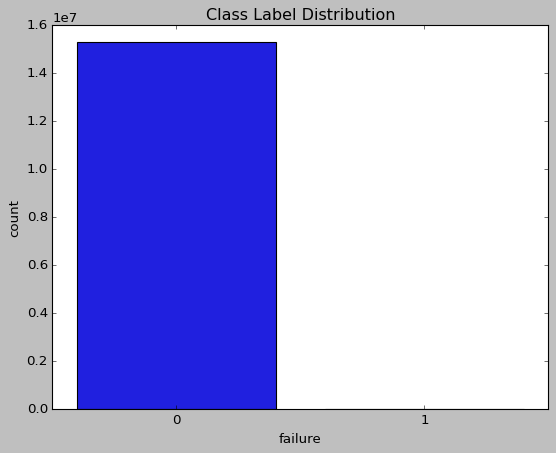

In [6]:
# look at the class label distribution
g = sns.countplot(q1.failure)
g.set_title('Class Label Distribution');

In [7]:
# create a list based on the sorted model frequency (highest to lowest) to use for plotting
model_frequency = q1.model.value_counts().reset_index().iloc[:,0].to_list()

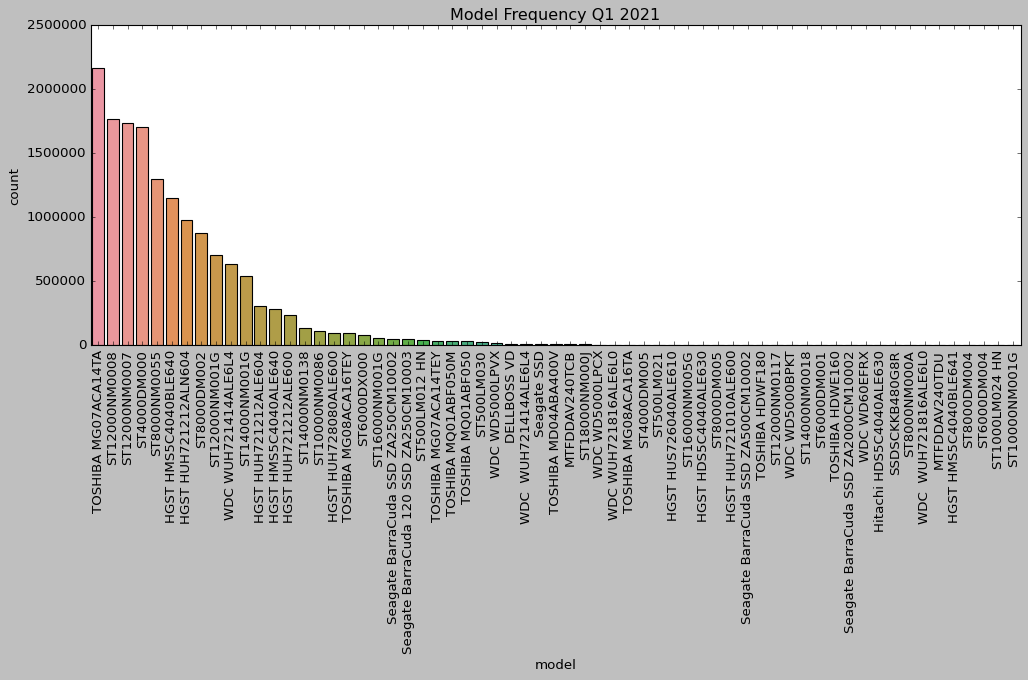

In [8]:
# look at the distribution of the different hdd models
plt.figure(figsize=(15, 5))
g = sns.countplot(q1.model, order=model_frequency)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Model Frequency Q1 2021');

In [9]:
# create a separate data frame with only failed data
failure_q1 = q1.query('failure == 1')

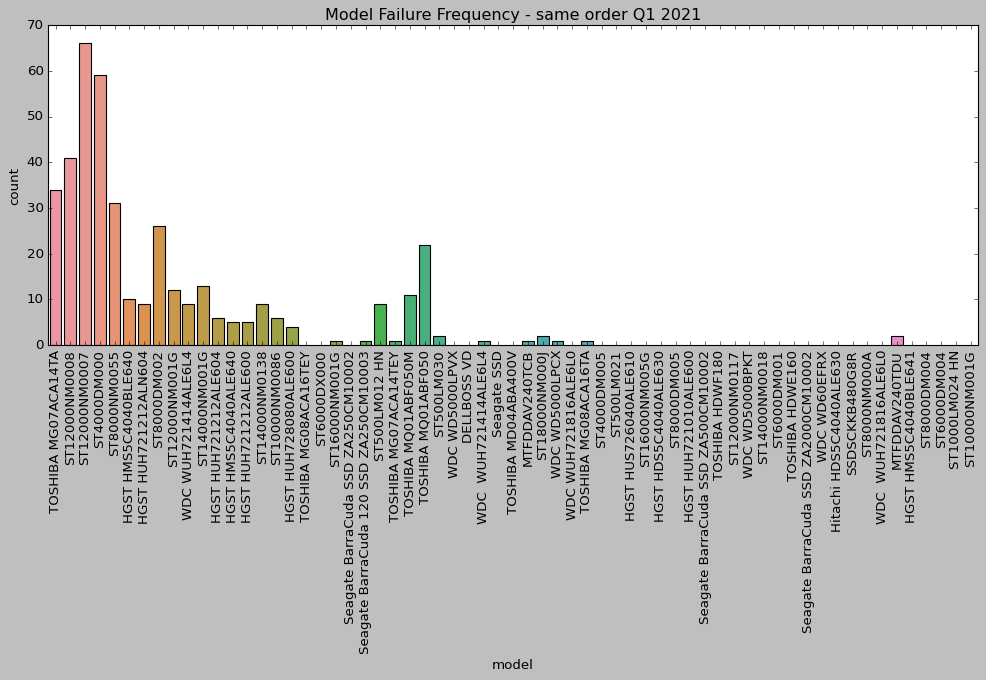

In [10]:
# plot the failure frequency per model in the same order as previous plot
plt.figure(figsize=(15, 5))
g = sns.countplot(failure_q1.model, order=model_frequency)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Model Failure Frequency - same order Q1 2021');

In [11]:
# create a new column order list based on failure frequency / ignores models without any failure in Q1
failure_frequency = failure_q1.model.value_counts().reset_index().iloc[:,0].to_list()

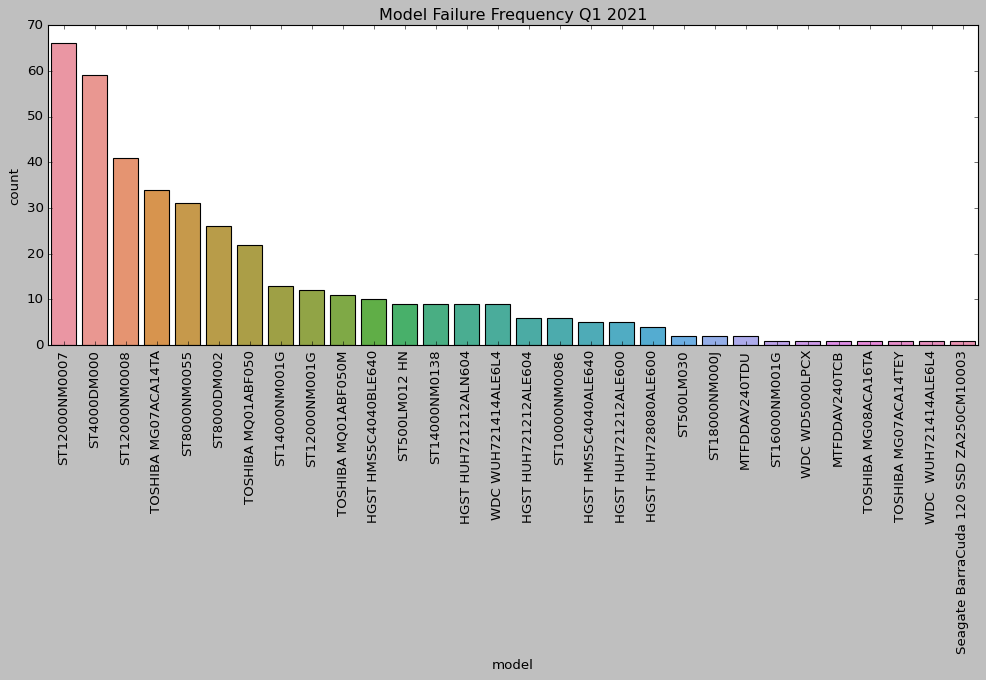

In [12]:
# plot failure frequency bt model type descending
plt.figure(figsize=(15, 5))
g = sns.countplot(failure_q1.model, order=failure_frequency)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Model Failure Frequency Q1 2021');

In [34]:
# print the Top 5 failure list
failure_frequency[:5]


['ST12000NM0007',
 'ST4000DM000',
 'ST12000NM0008',
 'TOSHIBA MG07ACA14TA',
 'ST8000NM0055']

In [35]:
most_failure = q1.query('model == "ST12000NM0007" or model == "ST4000DM000" or model == "ST12000NM0008" or model == "TOSHIBA MG07ACA14TA" or model == "ST8000NM0055"')

In [37]:
# create a crosstab for the index=country with the proporatons 
cross_tab_prop_failure = pd.crosstab(index=most_failure['model'],
                             columns=most_failure['failure'],
                             normalize="index")

# create a crosstab for the index=country on total values
cross_tab_failure = pd.crosstab(index=most_failure['model'],
                        columns=most_failure['failure'])

In [40]:
cross_tab_prop_failure.reset_index(inplace=True)

In [41]:
cross_tab_prop_failure.drop(['index'], axis=1, inplace=True)


In [42]:
cross_tab_prop_failure.sort_values(1, ascending=False, inplace=True)

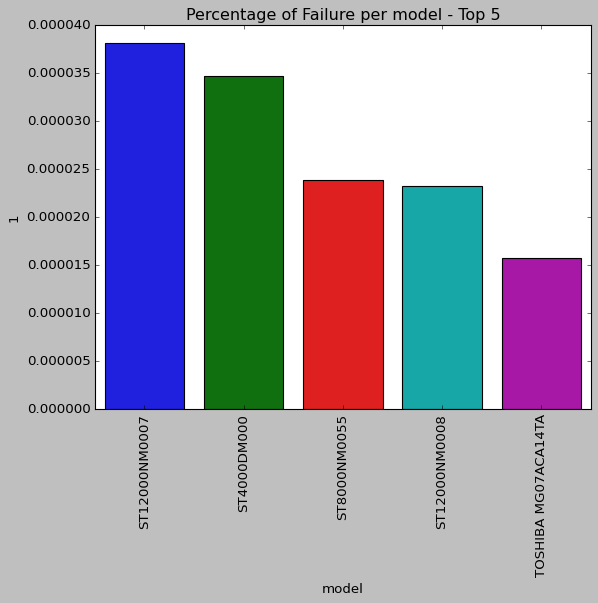

In [43]:
g = sns.barplot(data=cross_tab_prop_failure, x='model', y=1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Percentage of Failure per model - Top 5');

In [4]:
highest_failure = pd.read_sql("""
        SELECT model, COUNT(model), failure
        FROM public."2021" 
        GROUP BY model, failure
        HAVING failure = '1'
        ORDER BY count DESC
        """, db)

highest_failure.iloc[:5,]

,model,count,failure
0,ST4000DM000,610,1
1,ST12000NM0007,494,1
2,ST8000NM0055,392,1
3,ST12000NM0008,366,1
4,TOSHIBA MG07ACA14TA,347,1


With this we already can see that (at least for the q1 2021 data) the ST12000NM0007 has the highest percentage of failure in the data set. Thus, we very likely use this specific model along the project.

However, beforehand we look for all hard drives into the features at hand to get some insights into the S.M.A.R.T. features.

In [44]:
df = q1.query('date <= "2021-01-31"')
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
523351,2021-01-20,ZLW0EGC6,ST12000NM001G,12000138625024,0,83.0,202458512.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523352,2021-01-20,Z305B2QN,ST4000DM000,4000787030016,0,118.0,192473600.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523353,2021-01-20,ZLW0C6NE,ST12000NM001G,12000138625024,0,82.0,147894944.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523354,2021-01-20,ZJV0XJQ3,ST12000NM0007,12000138625024,0,83.0,184062176.0,NaN,NaN,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523355,2021-01-20,ZLW18MKT,ST14000NM001G,14000519643136,0,83.0,208950904.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df.pivot_table(index='serial_number', columns='smart_5_raw')

# going further into the details - load and pre-process the data for correlation / mutual_info check

we start by loading the full failure data set and a random sample of hard drives which have not been 

In [7]:
# load the test_model data for failures and success into specific data frames
test_model_failure = pd.read_csv('../data/special_purpose/ST4000DM000_failure.csv', parse_dates=['date'])
test_model_history = pd.read_csv('../data/special_purpose/ST4000DM000_history.csv', parse_dates=['date'])

# choose a random sample of the test_model_history to look into the correlation of features
test_model_success = test_model_history.query('failure == 0').sample(1000)

# concat the two separate data frames into one data frame
test_model_total = pd.concat([test_model_failure, test_model_success], axis=0)
test_model_total.reset_index(inplace=True)

test_model_total.drop('index', axis=1, inplace=True)
test_model_total.shape

(1610, 179)

In [8]:
# create a data frame for the overviw about the isnull values and a series containing the total count of the data frame
isnull = test_model_total.isnull().sum().reset_index(name='isnull')
total = pd.Series([test_model_total.shape[0] for _ in range(len(isnull))])

# create a dictionary and concat the the data to the data frame
data = {'isnull': isnull, 
        'total': total}

isnull = pd.concat(data, axis=1, ignore_index=True)

# give meaningful column names
isnull.columns = ['columns', 'isnull', 'total']

# add extra column containing the percentage of missing data per column
isnull['percentage_of_missing'] = isnull['isnull'] / isnull['total'] * 100

# create a list containing the column names which have more than specified percentage of missing values
drop_columns = isnull.query('percentage_of_missing > 40')['columns'].to_list()

# drop the columns with too much missing values from the data frame
test_model_total.drop(drop_columns, axis=1, inplace=True)

test_model_total.shape

(1610, 53)

In [9]:
# drop 5 rows which do not contain any smart data
test_model_total.dropna(how='any', inplace=True)
test_model_total.shape

(1610, 53)

#### Correlation Matrix

In [10]:
# check columns which only contain 0 values and drop them from the data frame
drop_columns = test_model_total.describe().T.query('mean == 0').reset_index()['index'].to_list()
test_model_total.drop(drop_columns, axis=1, inplace=True)

In [11]:
# construct correlation matrix
corr_mat = test_model_total.corr()

# drop columns which have no correlation at all
drop_columns = corr_mat[corr_mat['failure'].isnull()].reset_index()['index'].to_list()
test_model_total.drop(drop_columns, axis=1, inplace=True)

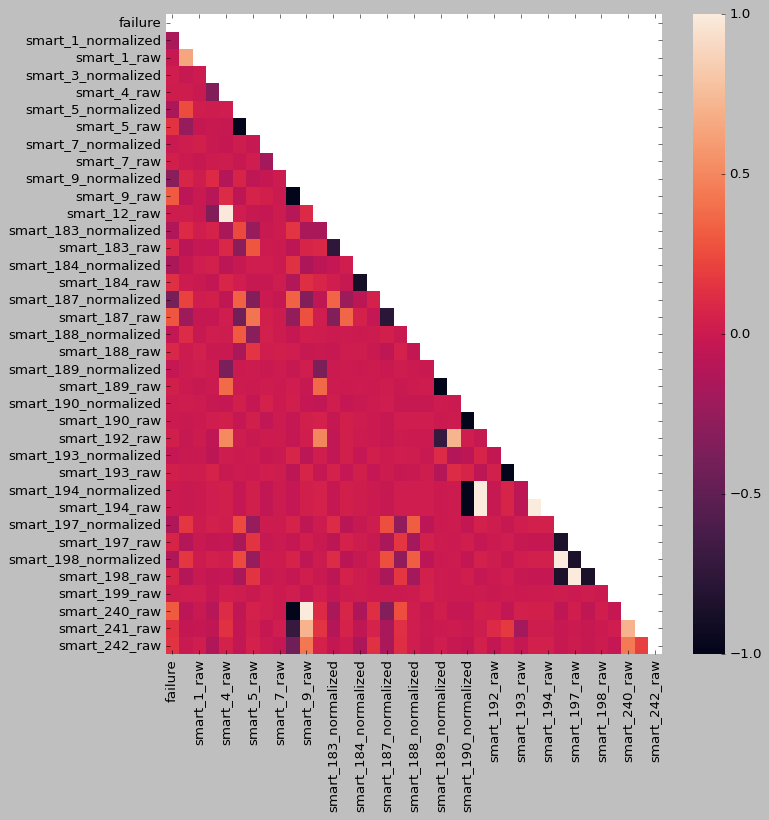

In [12]:
# create correlation matrix over all features
corr_mat = test_model_total.corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix)

In [13]:
# reset the index of the correlation matrix for further analysis (to find the features with the strongest correlation with failure)
corr_mat.reset_index(inplace=True)

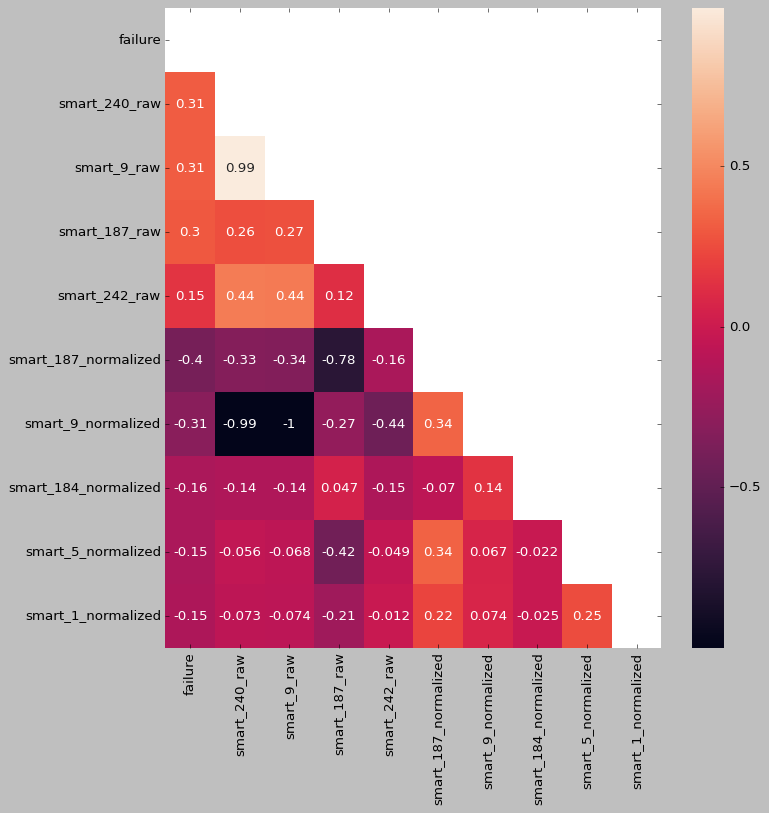

In [14]:
# reduce the correlation features to the most important ones
correlation_features = []

# identify the features with the highest positive correlation
for element in corr_mat.nlargest(5,'failure')['index']:
    correlation_features.append(element)

# identify the features with the highest negative correlation
for element in corr_mat.nsmallest(5,'failure')['index']:
    correlation_features.append(element)

# create correlation matrix over the top 10 features
corr_mat = test_model_total[correlation_features].corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix, annot=True)

#### Mutual Info

Split the data into X and y variables to check the mutual dependency of the different features in regards to the target variable

In [15]:
# split the data into X and y / focus on the most important features
X = test_model_total[correlation_features].drop('failure', axis=1)
y = test_model_total.failure

# create the mutual info classifier
mutual_info = mutual_info_classif(X, y)

# create a column list of the features used
columns = X.columns.to_list()

# concat the column names and the result from mutual_info
evaluation = pd.concat({"columns":pd.Series(columns),
                        'mutual_info': pd.Series(mutual_info)},
                         axis=1, ignore_index=True
)

evaluation.columns = ['feature', 'mutual_info']

display(evaluation.sort_values('mutual_info', ascending=False))

,feature,mutual_info
2,smart_187_raw,0.096291
4,smart_187_normalized,0.083494
1,smart_9_raw,0.069565
0,smart_240_raw,0.060825
5,smart_9_normalized,0.047925
8,smart_1_normalized,0.043688
7,smart_5_normalized,0.027218
6,smart_184_normalized,0.022492
3,smart_242_raw,0.012632


## Features

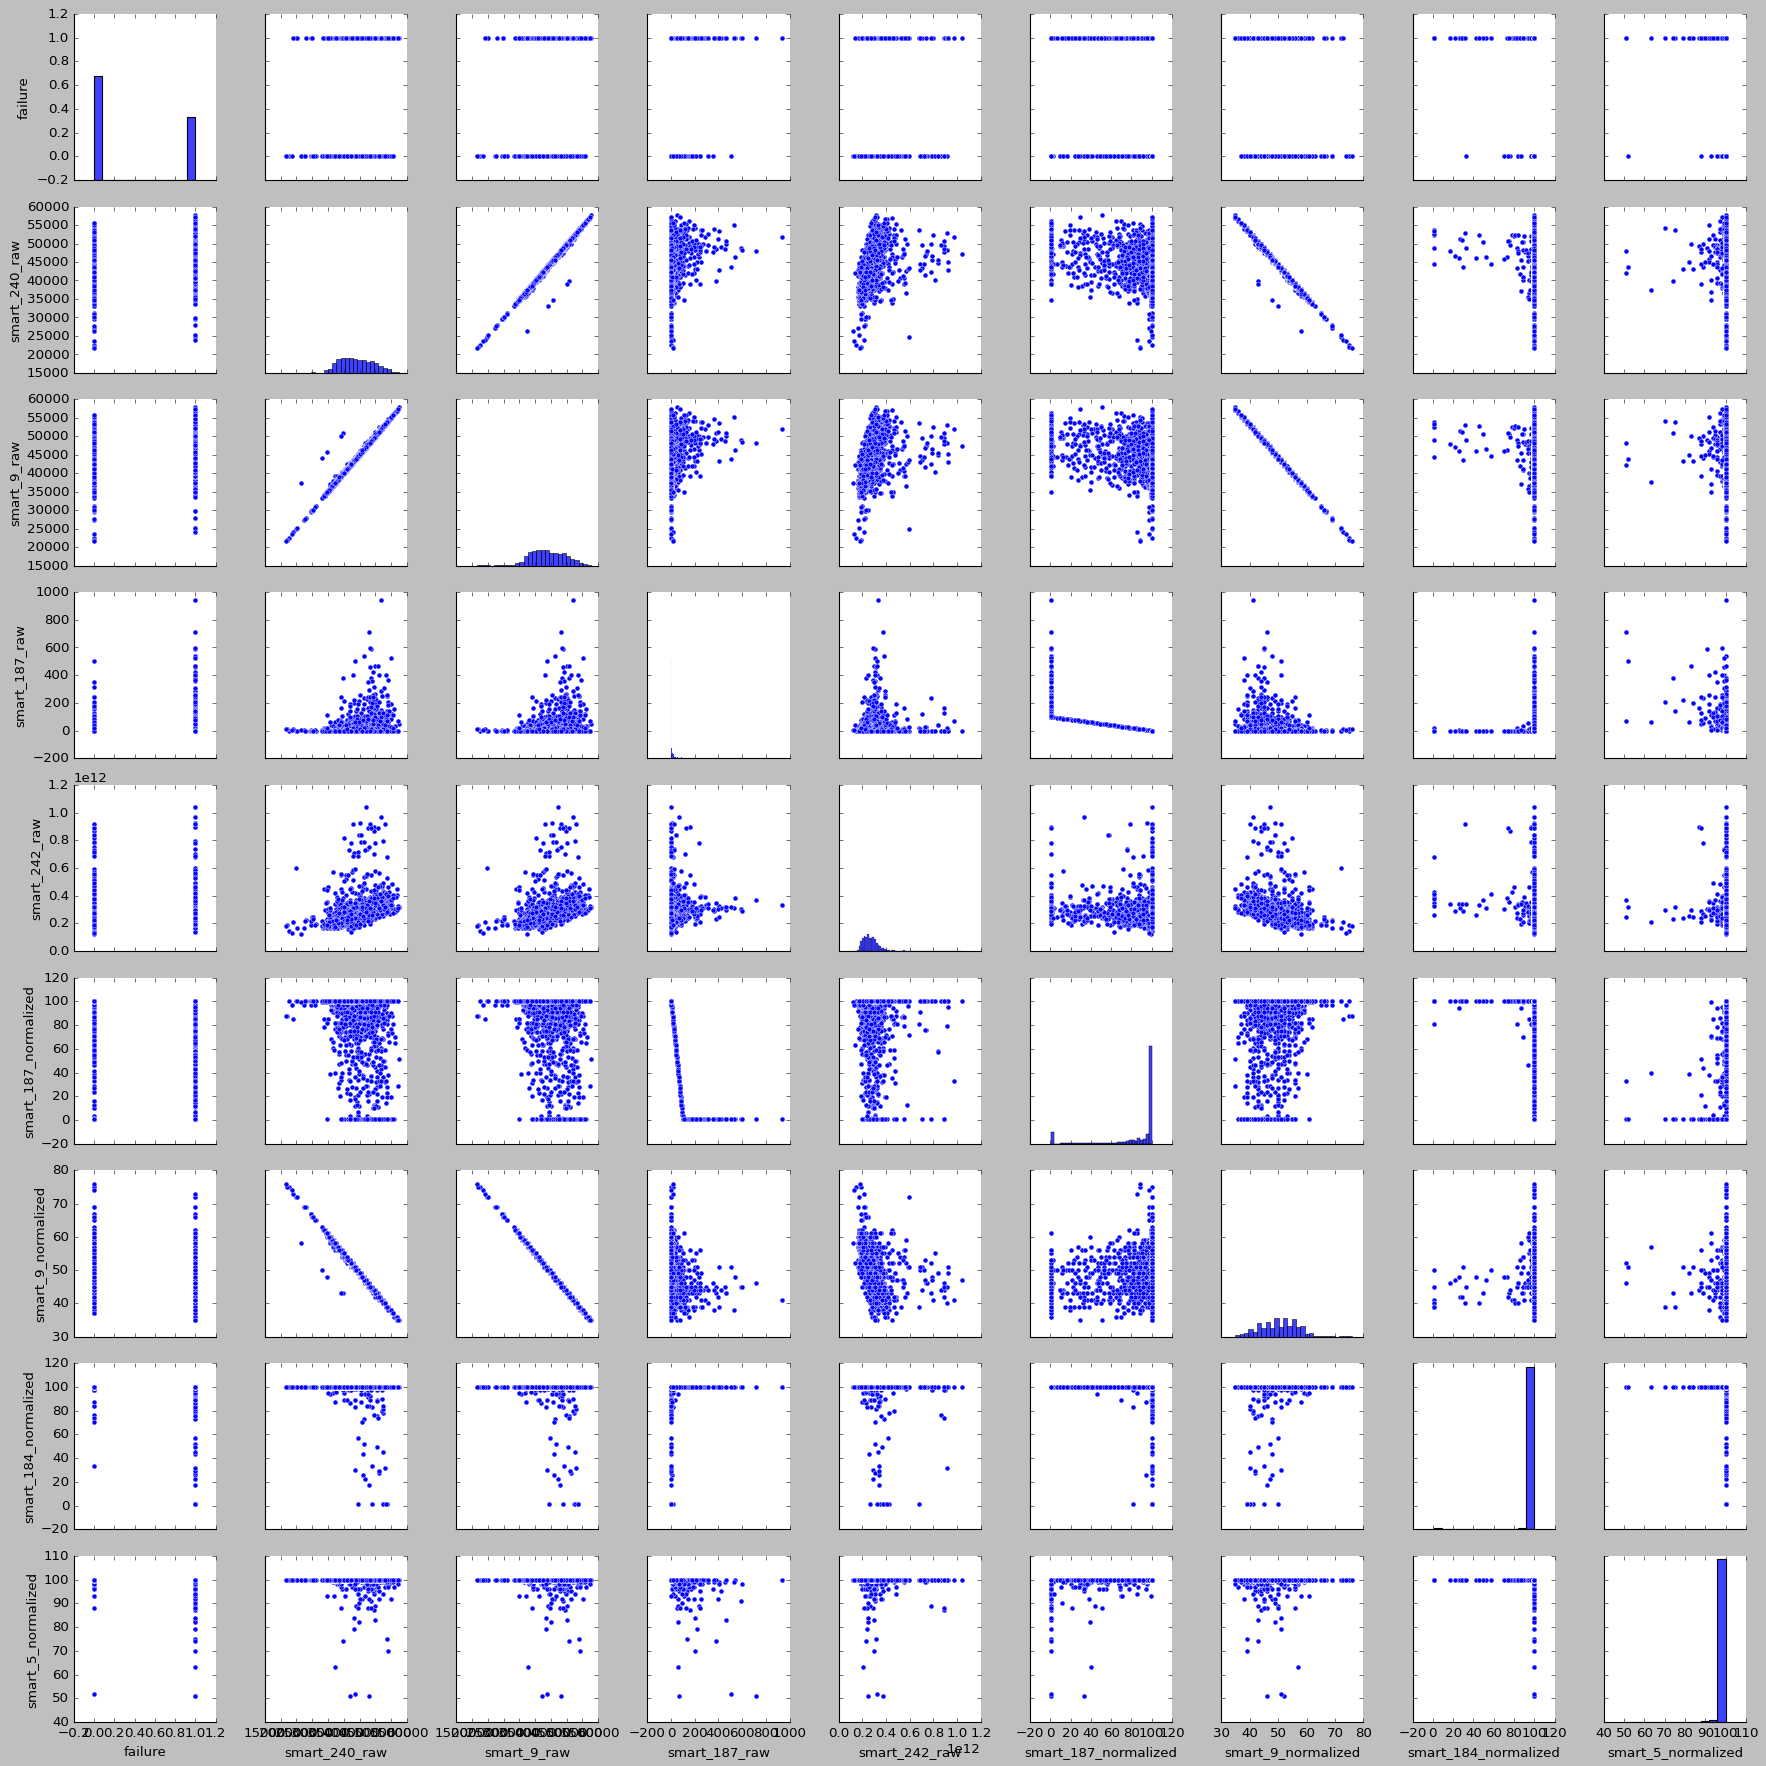

In [16]:
pairplot = test_model_total[correlation_features].reset_index()
sns.pairplot(pairplot.iloc[: ,1:-1]); 

In [17]:
all_columns = test_model_total.columns.to_list()

raw = []
norm = []

for element in all_columns:
    if 'raw' in element:
        raw.append(element)
    elif 'normalized' in element:
        norm.append(element)
    else:
        continue

raw_columns = []
norm_columns = []

for i in range(1, 255):
    if f'smart_{i}_raw'in raw and f'smart_{i}_normalized' in norm:
        raw_columns.append(f'smart_{i}_raw')
        norm_columns.append(f'smart_{i}_normalized')

feature = []

for element in raw_columns:
    feature.append(element.split('_')[1])

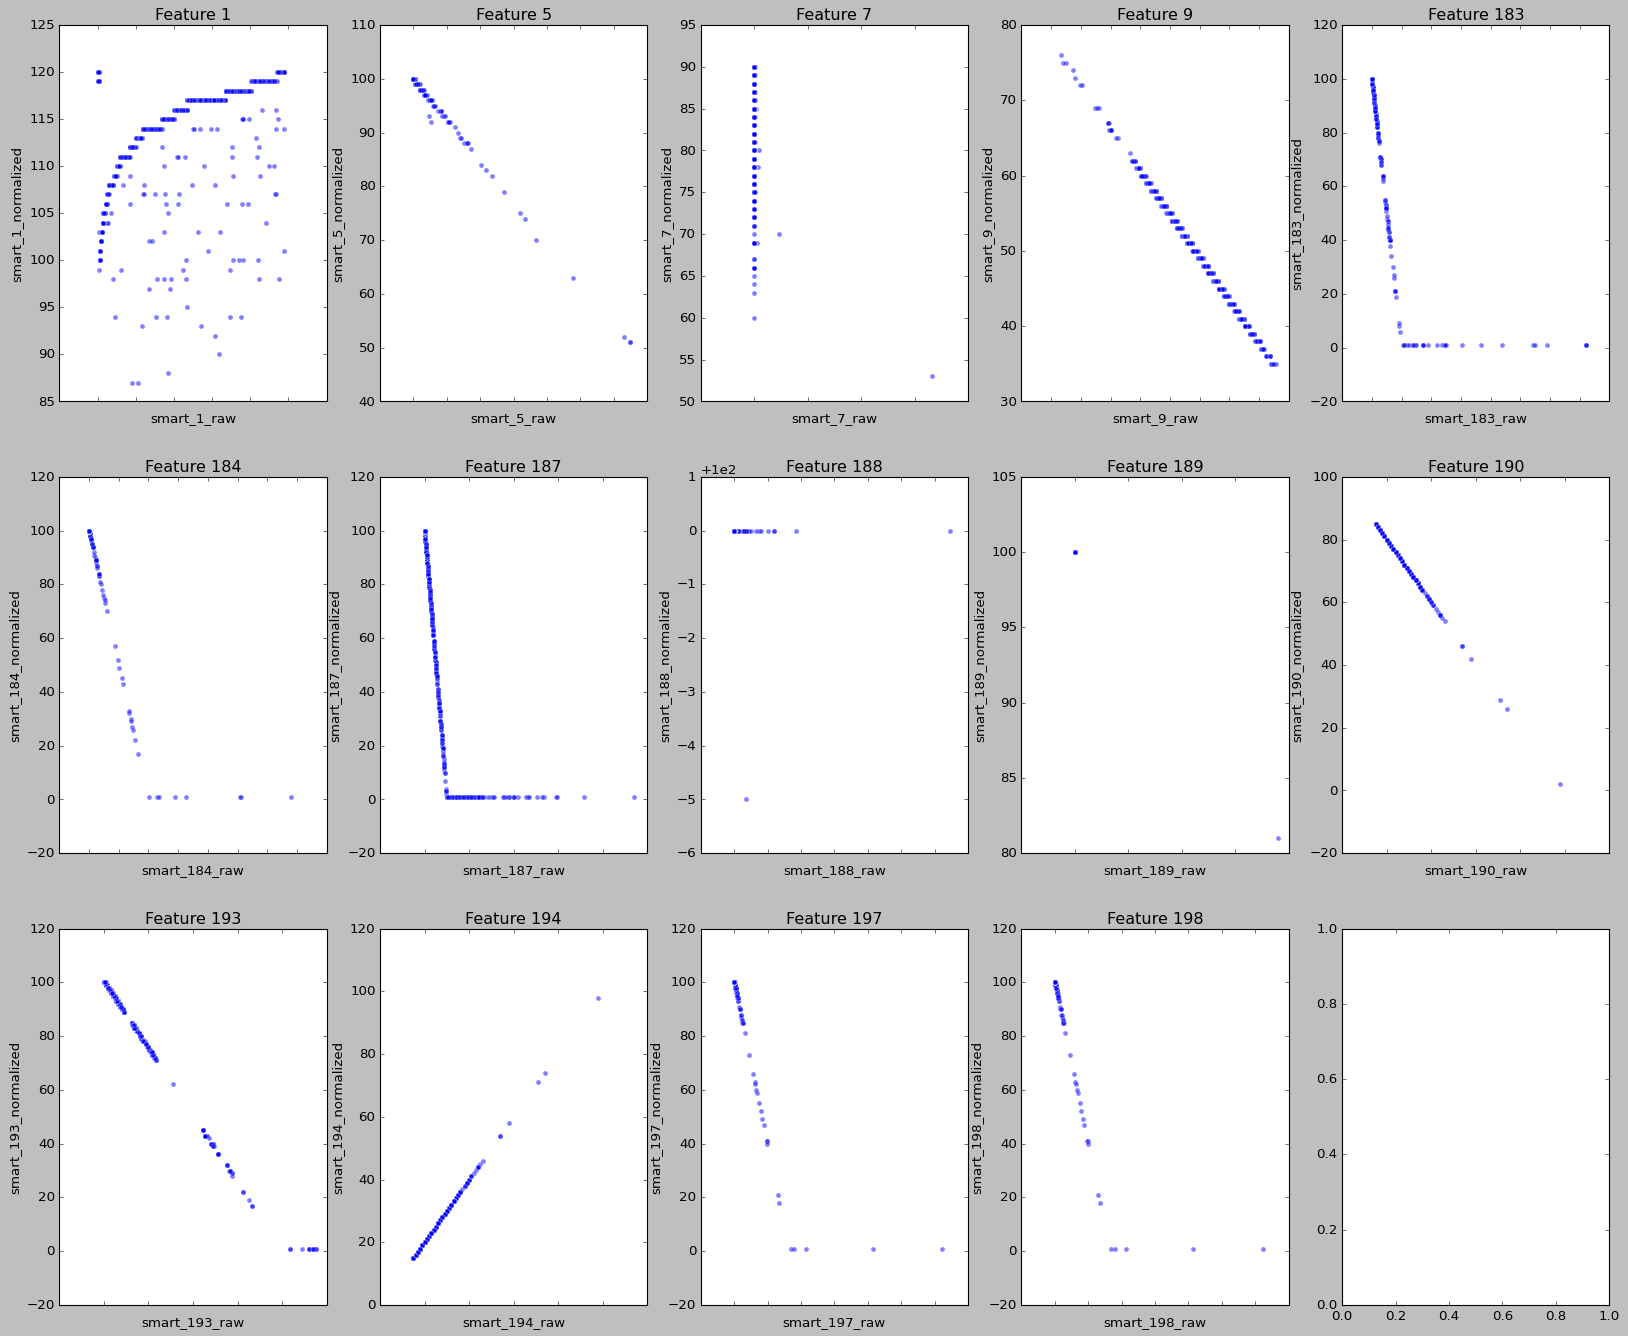

In [19]:
fig, ax = plt.subplots(3, 5, figsize=(25, 20))
counter = 0

for ind, val in enumerate(feature):
    sns.scatterplot(x=test_model_total[f'smart_{val}_raw'], y=test_model_total[f'smart_{val}_normalized'], ax=ax[counter, ind % 5], alpha=0.5)
    ax[counter, ind % 5].set_title(f'Feature {val}')
    ax[counter, ind % 5].set_xticklabels(ax[counter, ind % 5].get_xticklabels(), rotation=90)
    if ind == 4 or ind == 9 or ind == 14:
        counter += 1;

### load the main data set

In [86]:
# load the whole failure history data for one specific model (full history)
test_model_history = pd.read_csv('../data/special_purpose/ST4000DM000_history.csv', parse_dates=['date'])
test_model_history.shape

(241971, 179)

In [87]:
# drop one duplicate entry in the failure data frame (likely was repaired shortly before failing again)
display(test_model_failure[test_model_failure.duplicated('serial_number')])
test_model_failure.drop_duplicates(keep='first', subset=None, inplace=True)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw


## Create function for countdown target

In [88]:
# create a date_failure column
test_model_history['date_failure'] = test_model_history['serial_number'].map(test_model_failure.set_index('serial_number')['date'])

In [89]:
test_model_history.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw,date_failure
0,2020-09-15,Z304KBK4,ST4000DM000,4000787030016,0,113.0,53991680.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-16
1,2020-09-15,Z304JGH0,ST4000DM000,4000787030016,0,111.0,31142392.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-14
2,2020-09-15,Z302SYHL,ST4000DM000,4000787030016,0,120.0,238681648.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-22
3,2020-09-15,S3010L7K,ST4000DM000,4000787030016,0,118.0,180888736.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-11
4,2020-09-15,Z304JM6A,ST4000DM000,4000787030016,0,114.0,59625576.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-24


In [90]:
# create a data frame for the overview about the isnull values and a series containing the total count of the data frame
isnull = test_model_history.isnull().sum().reset_index(name='isnull')
total = pd.Series([test_model_history.shape[0] for _ in range(len(isnull))])

# create a dictionary and concat the the data to the data frame
data = {'isnull': isnull, 
        'total': total}

isnull = pd.concat(data, axis=1, ignore_index=True)

# give meaningful column names
isnull.columns = ['columns', 'isnull', 'total']

# add extra column containing the percentage of missing data per column
isnull['percentage_of_missing'] = isnull['isnull'] / isnull['total'] * 100

# create a list containing the column names which have more than specified percentage of missing values
drop_columns = isnull.query('percentage_of_missing > 40')['columns'].to_list()

# drop the columns with too much missing values from the data frame
test_model_history.drop(drop_columns, axis=1, inplace=True)

In [91]:
# create a new column called countdown
test_model_history['countdown'] = test_model_history['date_failure'] - test_model_history['date']

# convert countdown from date object into integer for regression
test_model_history['countdown'] = test_model_history['countdown'].apply(lambda x: x / np.timedelta64(1,'D'))

In [92]:
# drop 11 rows which do not contain any smart data
test_model_history.dropna(how='any', inplace=True)
test_model_history.shape

(241952, 55)

In [93]:
# remove data where countdown is negative (e.g. where a hard drive has been repaired/restored after failure without new failure date)
test_model_history = test_model_history.query('countdown >= 0')
test_model_history.countdown.value_counts()

0.0      610
3.0      606
2.0      605
11.0     604
1.0      604
        ... 
729.0      2
728.0      2
727.0      2
726.0      2
730.0      1
Name: countdown, Length: 731, dtype: int64

In [94]:
# check for one serial number and return data frame
serial = test_model_history.loc[0, 'serial_number']
test_model_history[test_model_history['serial_number'] == serial].sort_values('countdown',ascending=True)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,date_failure,countdown
204543,2021-12-16,Z304KBK4,ST4000DM000,4000787030016,1,117.0,164860688.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54228.0,100.0,6.559082e+10,100.0,4.247316e+11,2021-12-16,0.0
204653,2021-12-15,Z304KBK4,ST4000DM000,4000787030016,0,120.0,237276656.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54204.0,100.0,6.557860e+10,100.0,4.244502e+11,2021-12-16,1.0
204602,2021-12-14,Z304KBK4,ST4000DM000,4000787030016,0,114.0,70573816.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54180.0,100.0,6.556668e+10,100.0,4.242459e+11,2021-12-16,2.0
204843,2021-12-13,Z304KBK4,ST4000DM000,4000787030016,0,119.0,234716472.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54156.0,100.0,6.555284e+10,100.0,4.239353e+11,2021-12-16,3.0
204818,2021-12-12,Z304KBK4,ST4000DM000,4000787030016,0,117.0,133021288.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54132.0,100.0,6.554253e+10,100.0,4.237327e+11,2021-12-16,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104116,2020-01-05,Z304KBK4,ST4000DM000,4000787030016,0,117.0,125085048.0,92.0,0.0,100.0,...,200.0,0.0,100.0,37155.0,100.0,5.544780e+10,100.0,2.384597e+11,2021-12-16,711.0
98905,2020-01-04,Z304KBK4,ST4000DM000,4000787030016,0,117.0,147086336.0,92.0,0.0,100.0,...,200.0,0.0,100.0,37131.0,100.0,5.542732e+10,100.0,2.382322e+11,2021-12-16,712.0
92203,2020-01-03,Z304KBK4,ST4000DM000,4000787030016,0,119.0,202074456.0,92.0,0.0,100.0,...,200.0,0.0,100.0,37108.0,100.0,5.541177e+10,100.0,2.379431e+11,2021-12-16,713.0
88985,2020-01-02,Z304KBK4,ST4000DM000,4000787030016,0,114.0,66175168.0,92.0,0.0,100.0,...,200.0,0.0,100.0,37084.0,100.0,5.539814e+10,100.0,2.376770e+11,2021-12-16,714.0


## Correlation for Countdown

In [95]:
# check columns which only contain 0 values and drop them from the data frame
drop_columns = test_model_history.describe().T.query('mean == 0').reset_index()['index'].to_list()
test_model_history.drop(drop_columns, axis=1, inplace=True)

In [96]:
test_model_history.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,...,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,date_failure,countdown
0,2020-09-15,Z304KBK4,ST4000DM000,4000787030016,0,113.0,53991680.0,92.0,100.0,14.0,...,200.0,0.0,100.0,43260.0,100.0,5.936166e+10,100.0,3.123054e+11,2021-12-16,457.0
1,2020-09-15,Z304JGH0,ST4000DM000,4000787030016,0,111.0,31142392.0,91.0,100.0,13.0,...,200.0,0.0,100.0,42459.0,100.0,5.902419e+10,100.0,2.553616e+11,2021-01-14,121.0
2,2020-09-15,Z302SYHL,ST4000DM000,4000787030016,0,120.0,238681648.0,92.0,100.0,22.0,...,200.0,0.0,100.0,43769.0,100.0,6.132206e+10,100.0,2.526737e+11,2021-05-22,249.0
3,2020-09-15,S3010L7K,ST4000DM000,4000787030016,0,118.0,180888736.0,94.0,100.0,6.0,...,200.0,0.0,100.0,46589.0,100.0,6.335880e+10,100.0,2.237496e+11,2020-12-11,87.0
4,2020-09-15,Z304JM6A,ST4000DM000,4000787030016,0,114.0,59625576.0,92.0,100.0,16.0,...,200.0,0.0,100.0,43281.0,100.0,5.857410e+10,100.0,2.774035e+11,2021-01-24,131.0


In [97]:
# construct correlation matrix
corr_mat = test_model_history.corr()

# drop columns which have no correlation at all
drop_columns = corr_mat[corr_mat['failure'].isnull()].reset_index()['index'].to_list()
test_model_history.drop(drop_columns, axis=1, inplace=True)

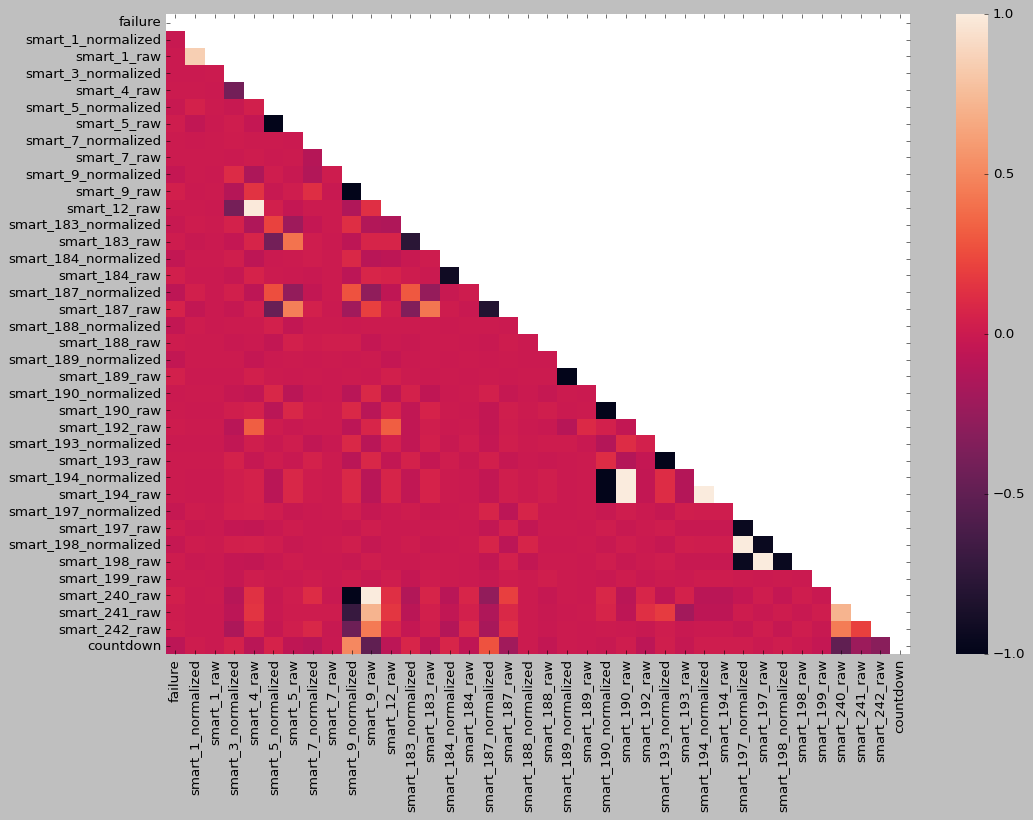

In [98]:
# create correlation matrix over all features
corr_mat = test_model_history.corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(15,10))
g = sns.heatmap(corr_mat, mask=matrix)

In [99]:
# reset the index of the correlation matrix for further analysis (to find the features with the strongest correlation with failure)
corr_mat.reset_index(inplace=True)

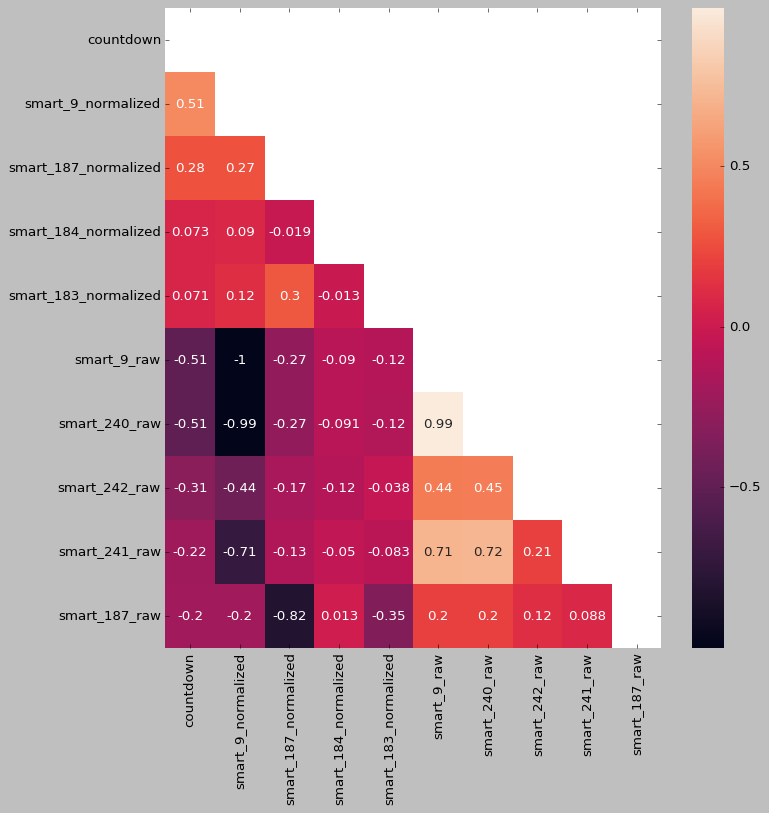

In [100]:
# reduce the correlation features to the most important ones
correlation_features = []

# identify the features with the highest positive correlation
for element in corr_mat.nlargest(5,'countdown')['index']:
    correlation_features.append(element)

# identify the features with the highest negative correlation
for element in corr_mat.nsmallest(5,'countdown')['index']:
    correlation_features.append(element)

# create correlation matrix over the top 10 features
corr_mat = test_model_history[correlation_features].corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix, annot=True)

In [101]:
# lineplot = test_model_history[test_model_history['serial_number'] == serial]
columns = []

for col in test_model_history.columns:
    if 'smart' in col:
        columns.append(col)

In [107]:
test_model_history.query('countdown < 0')

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown


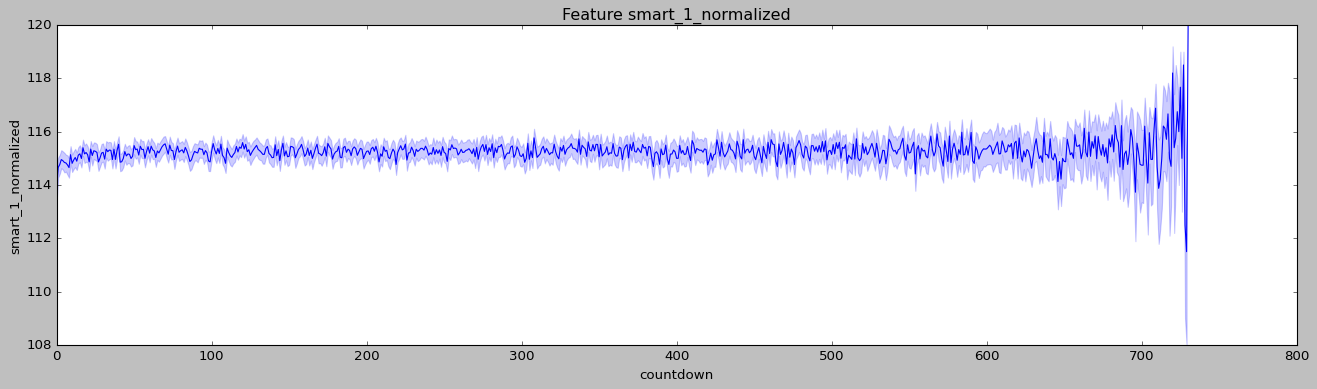

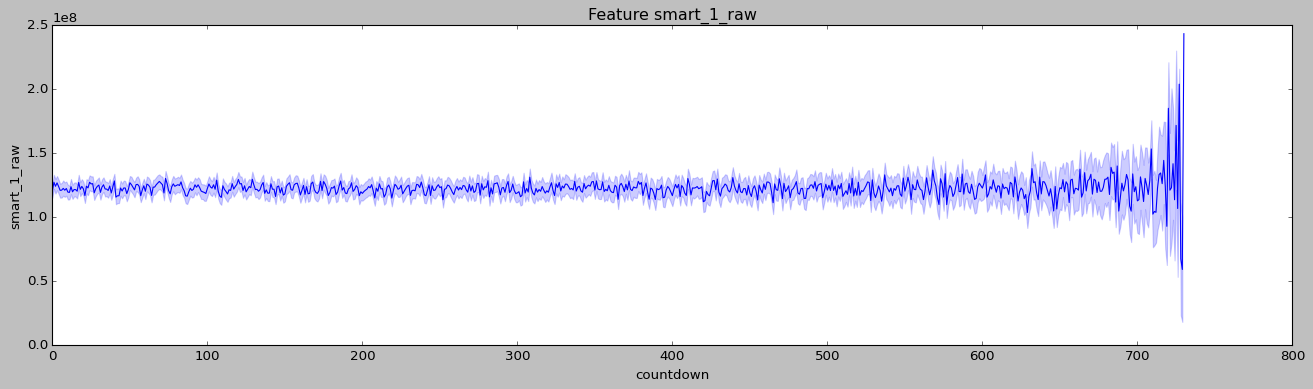

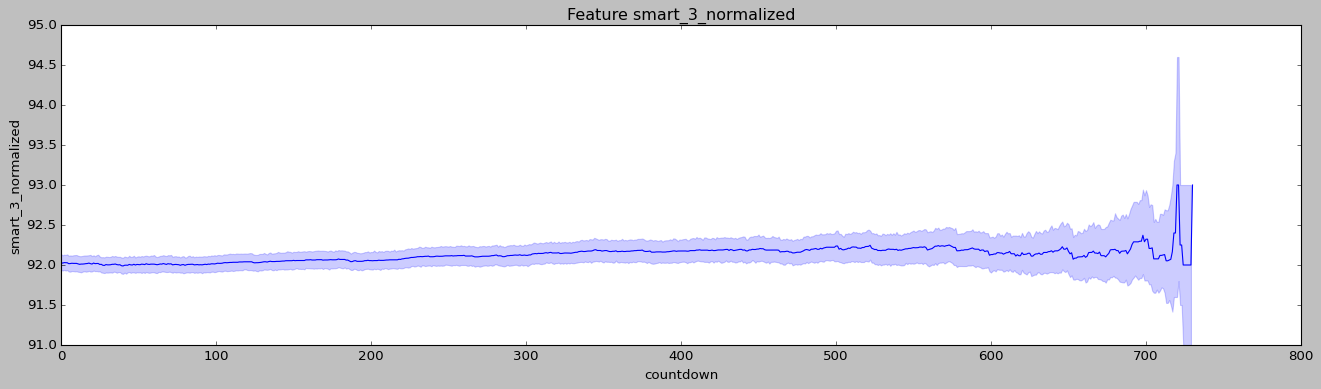

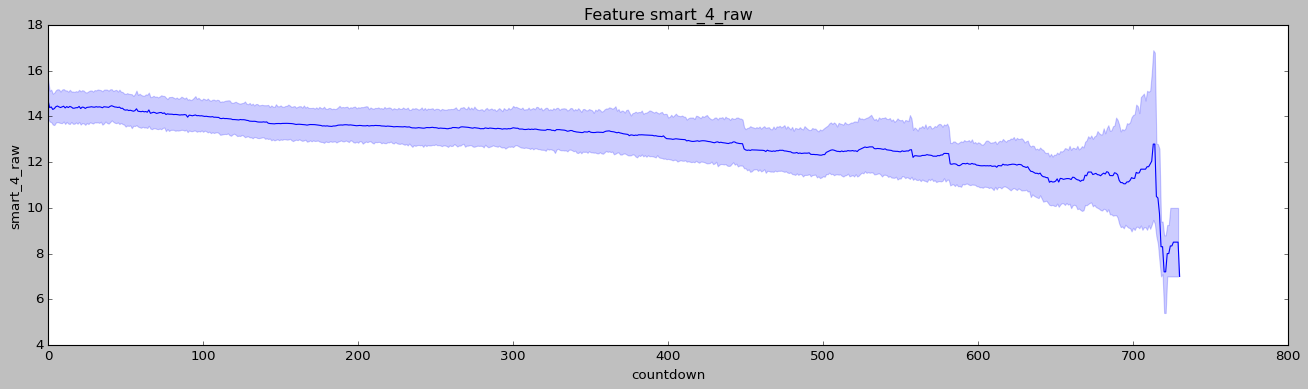

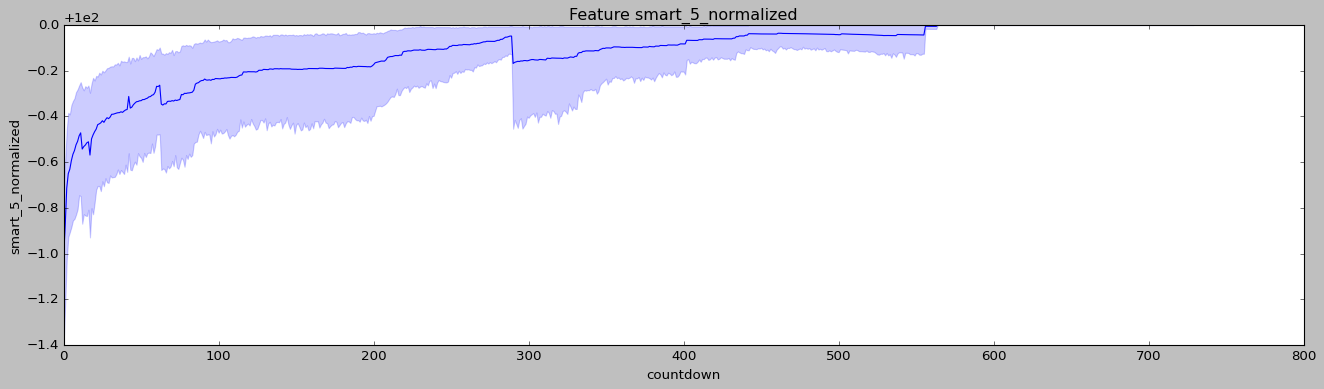

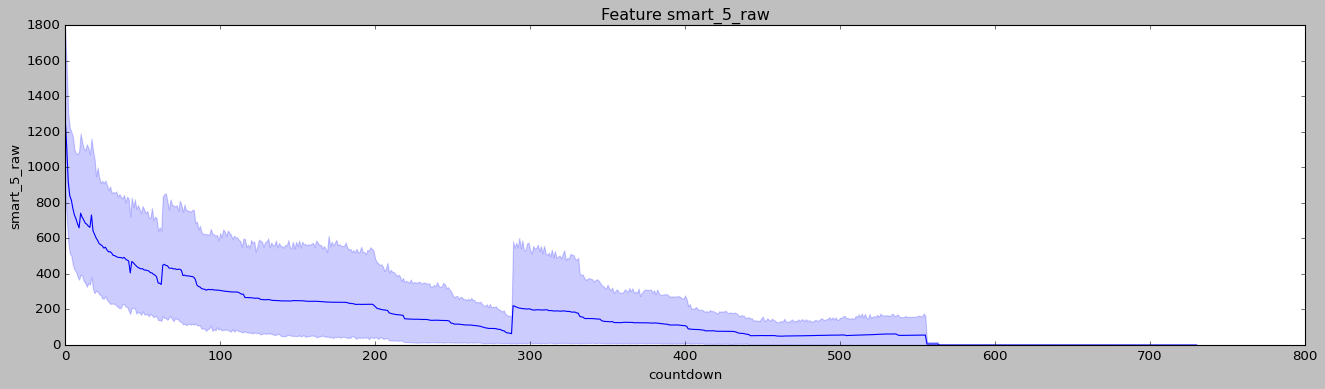

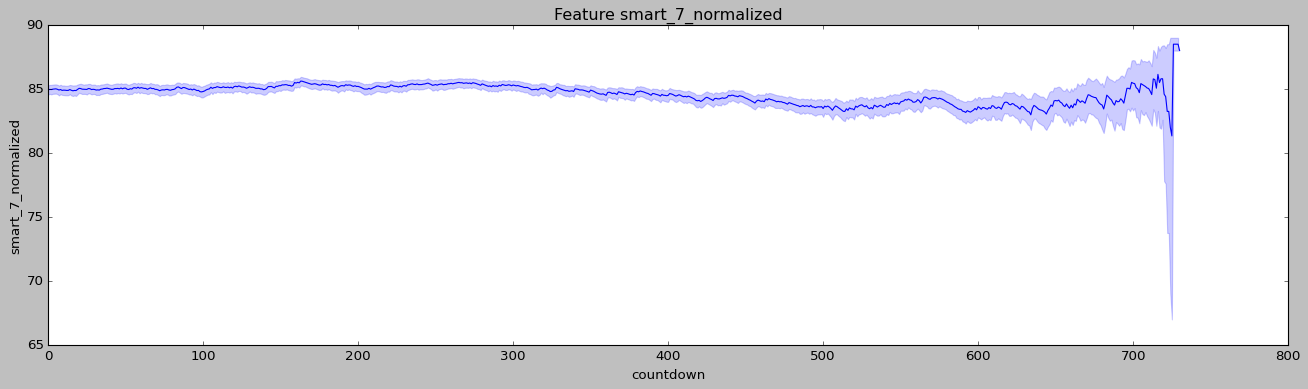

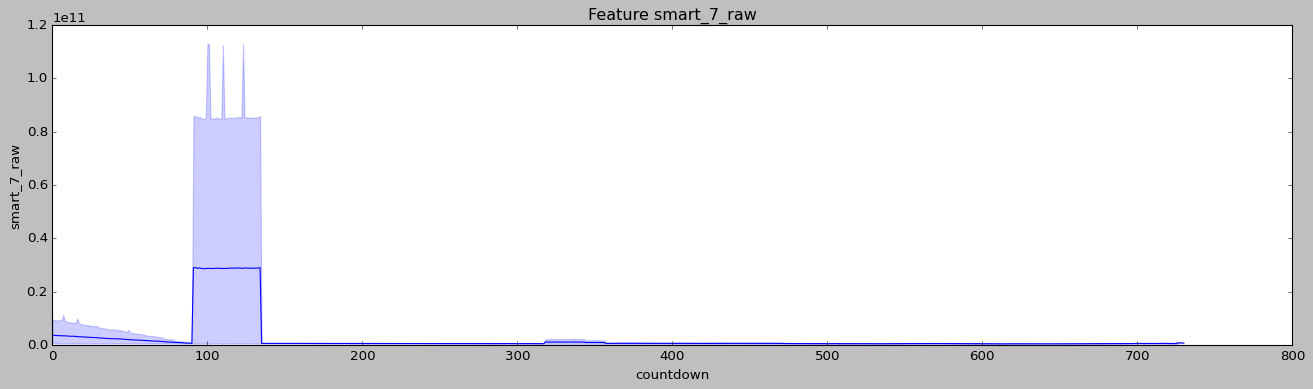

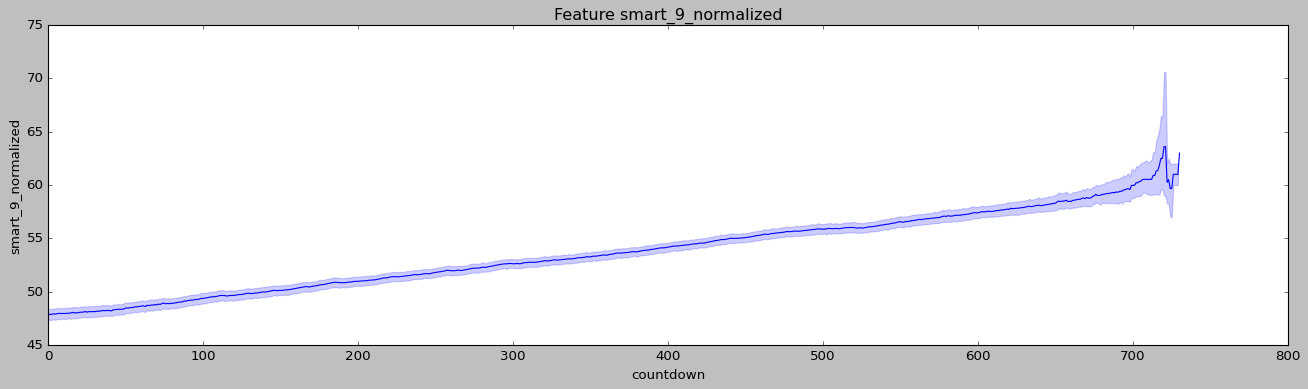

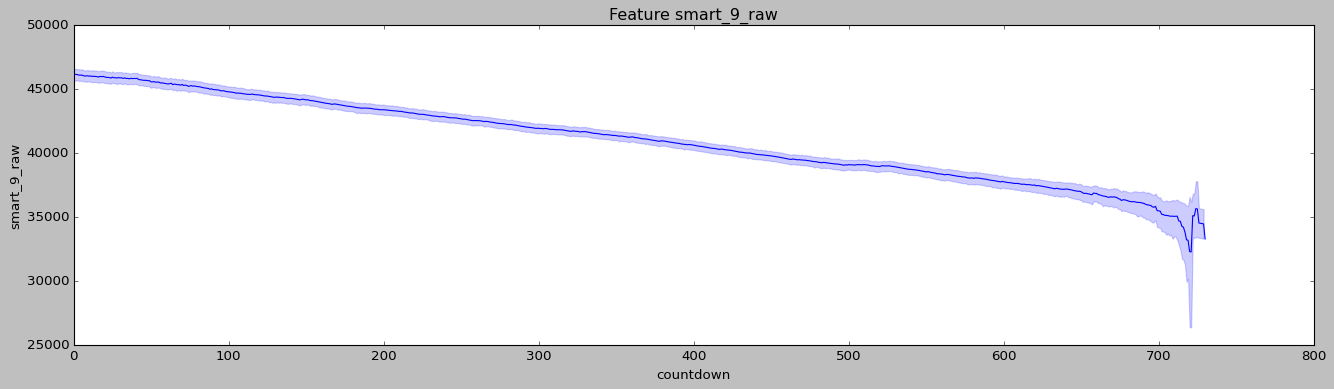

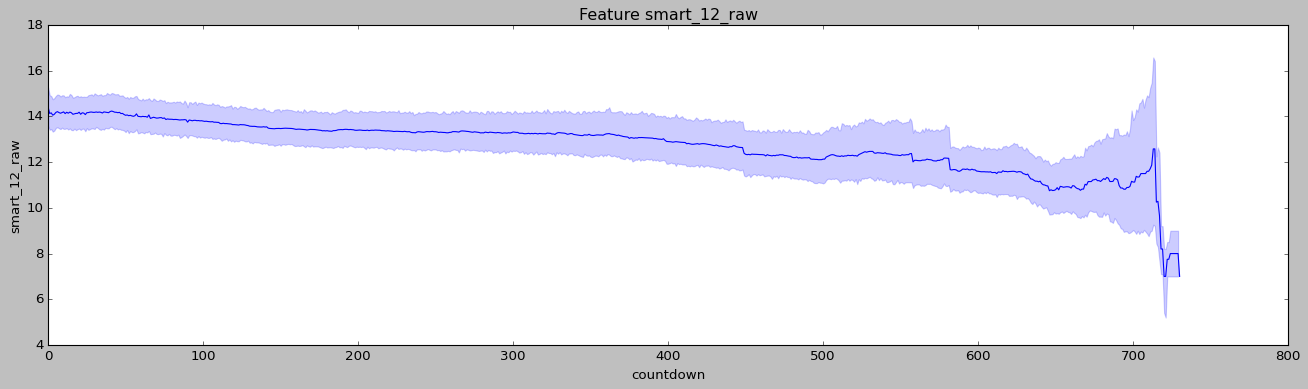

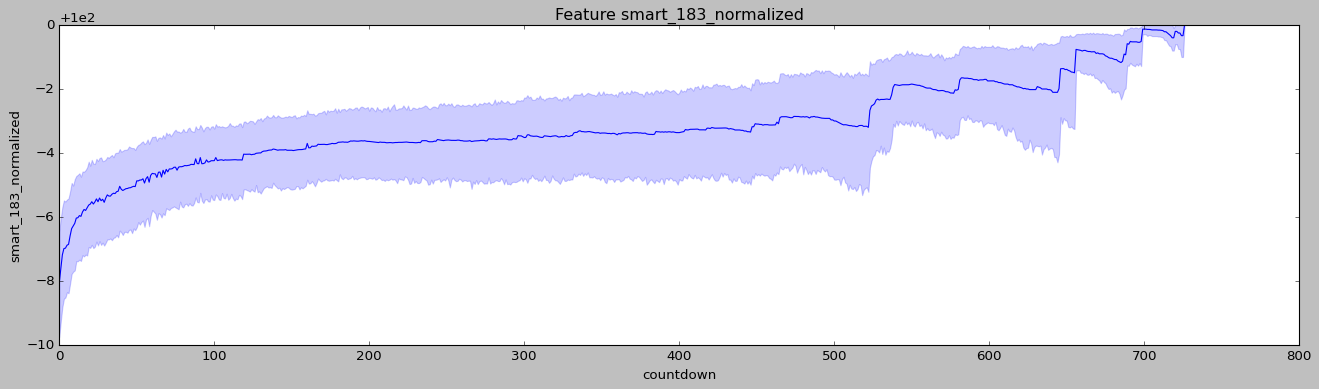

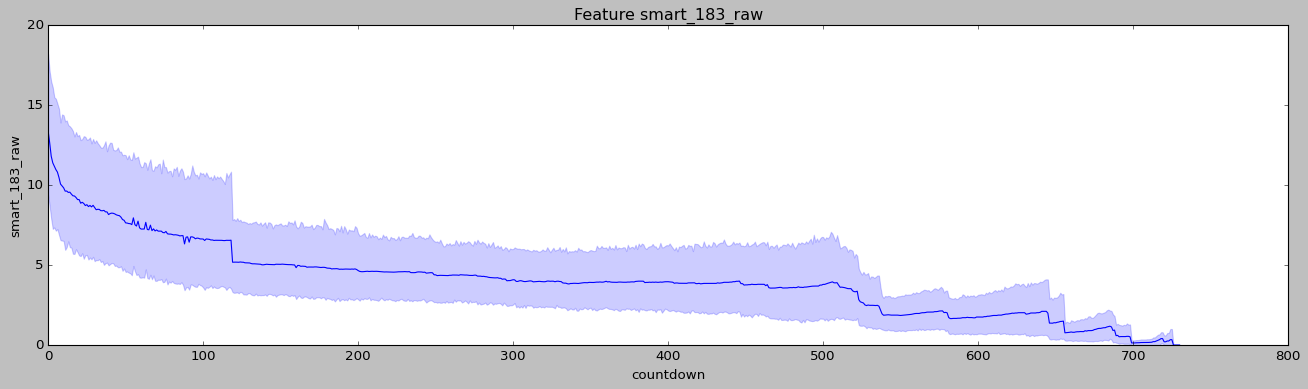

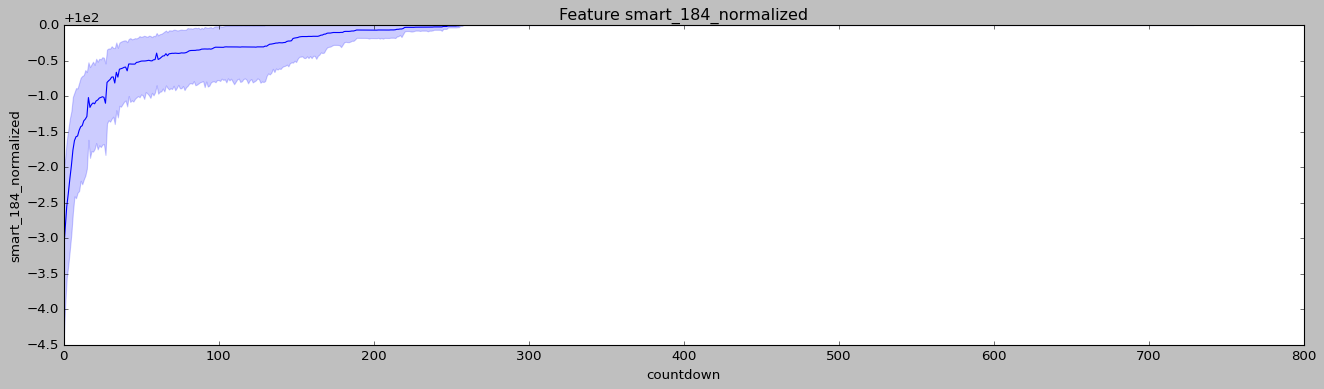

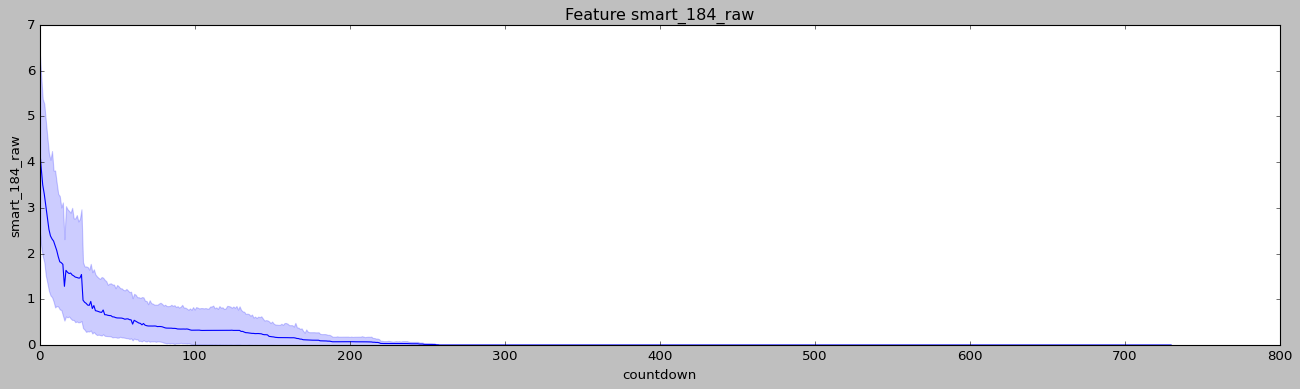

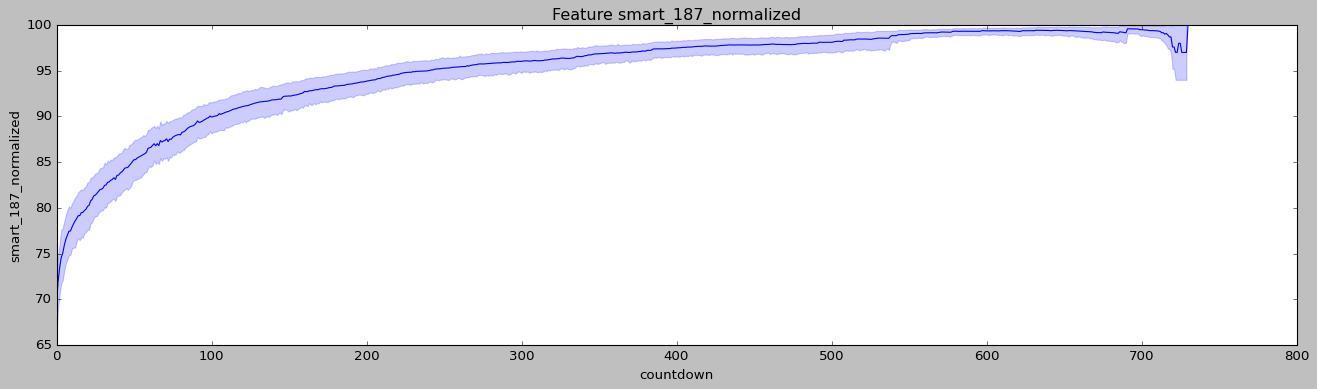

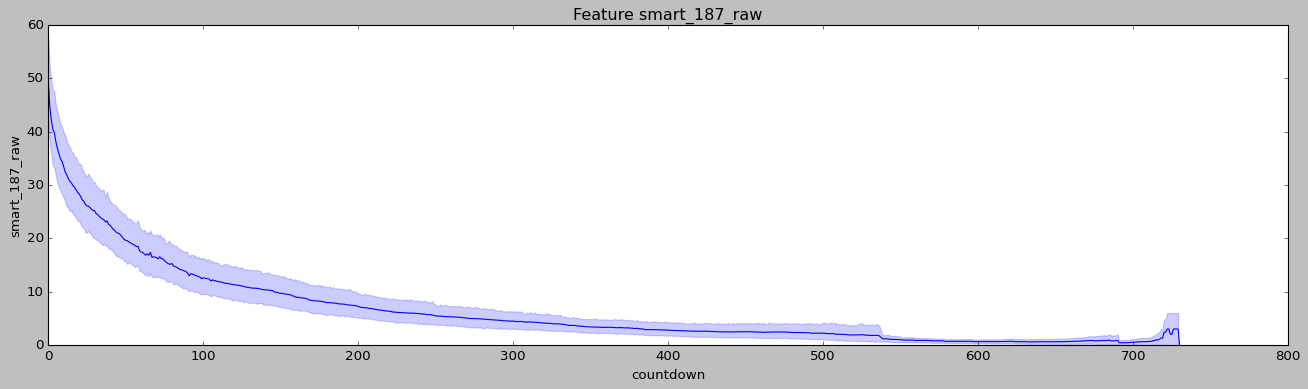

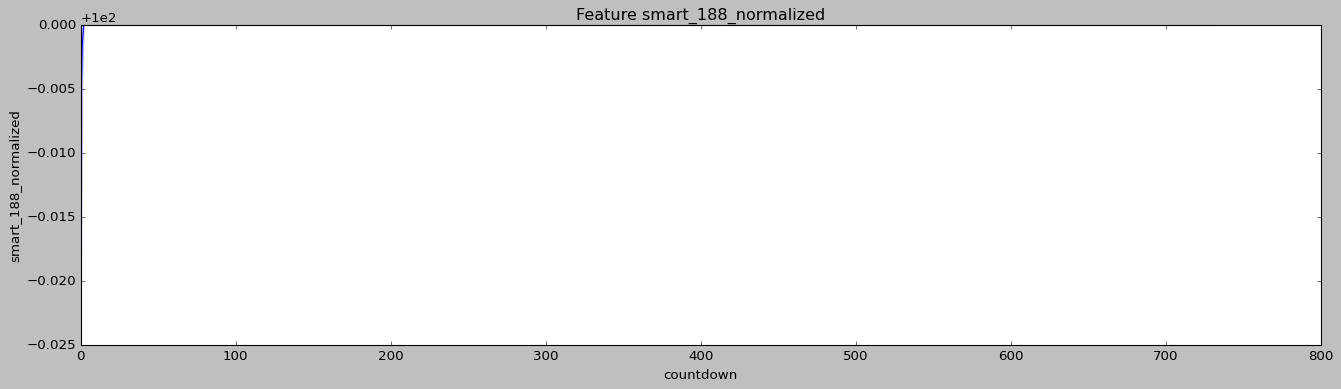

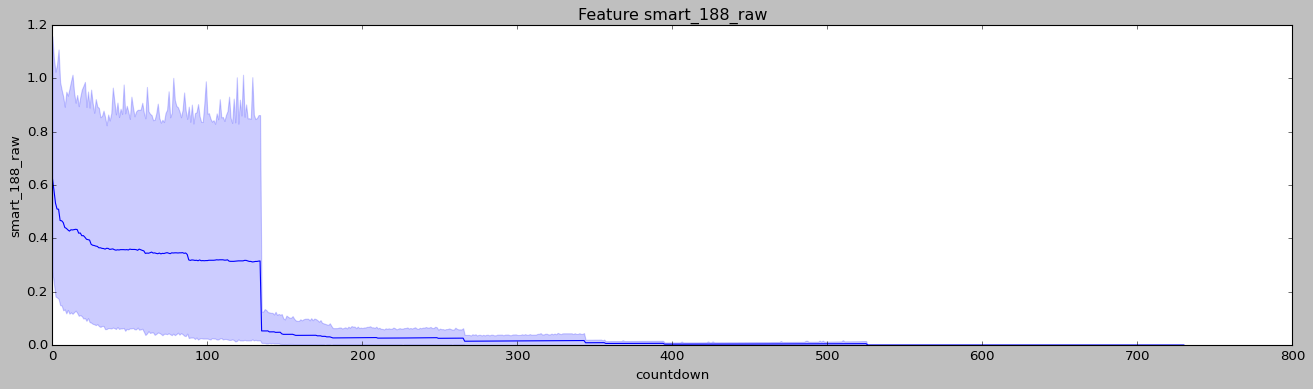

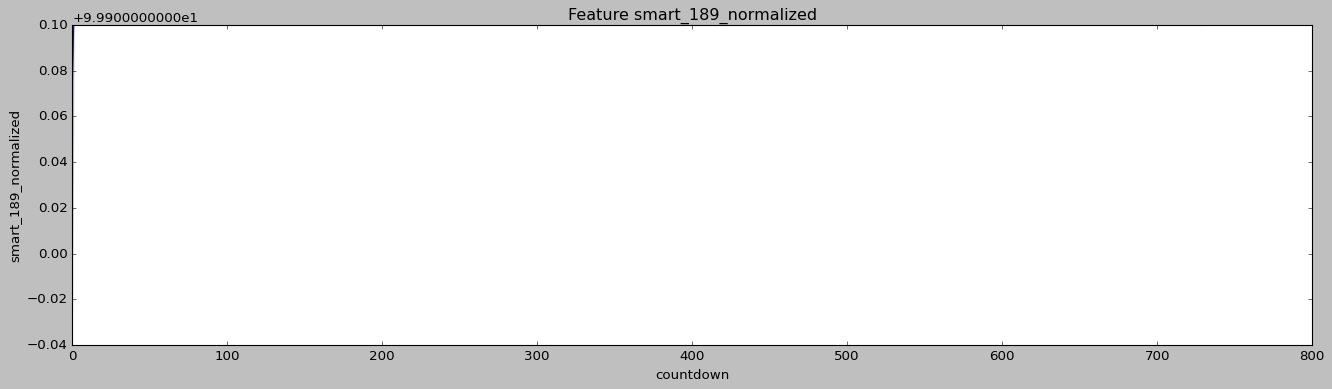

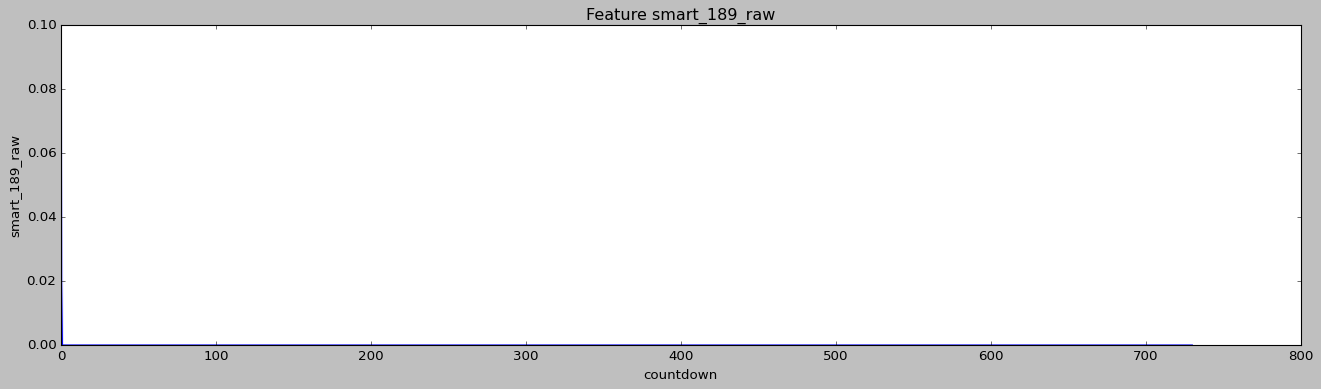

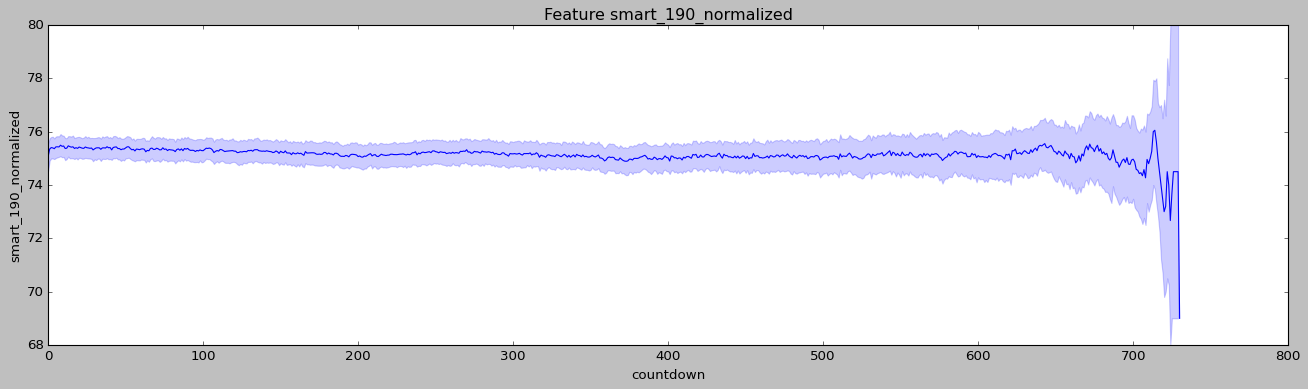

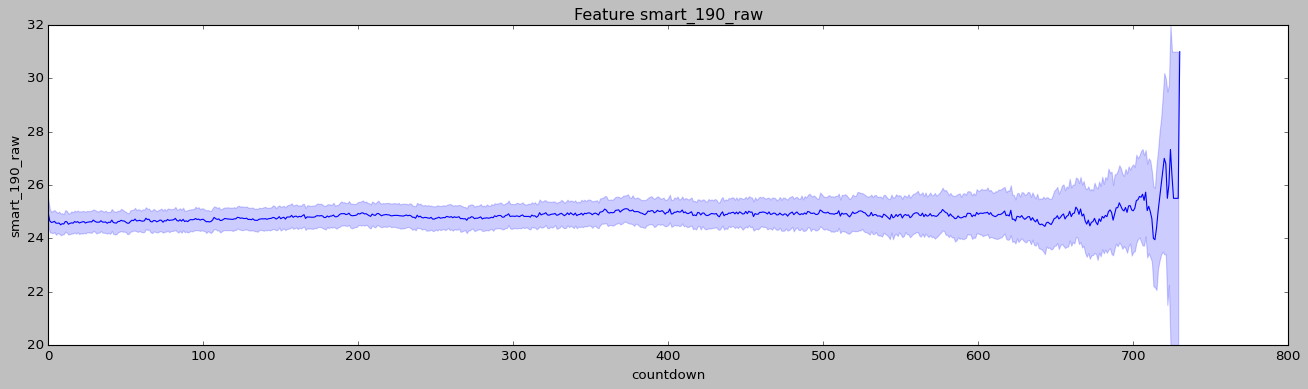

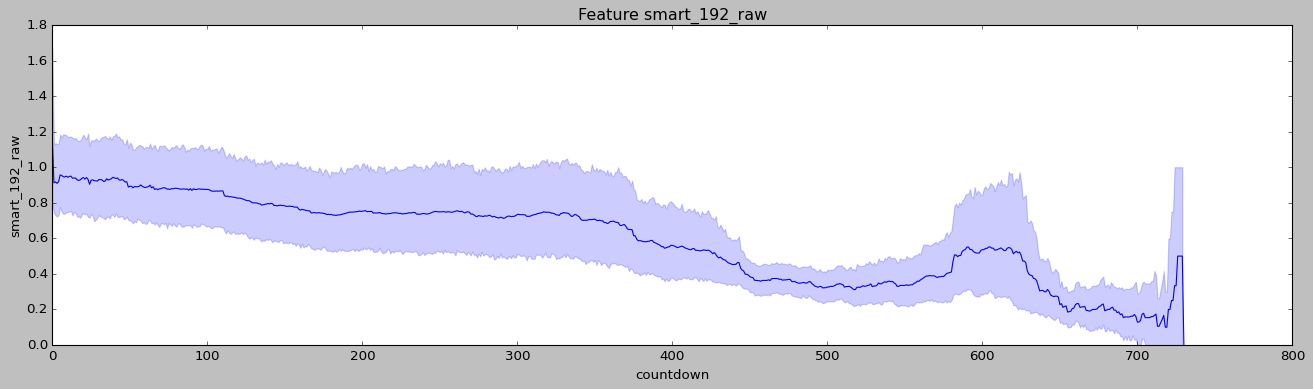

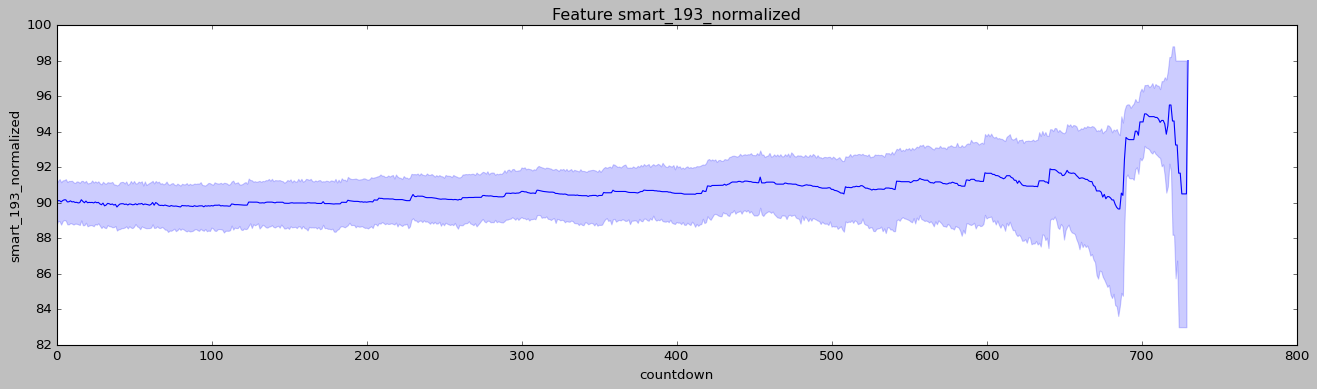

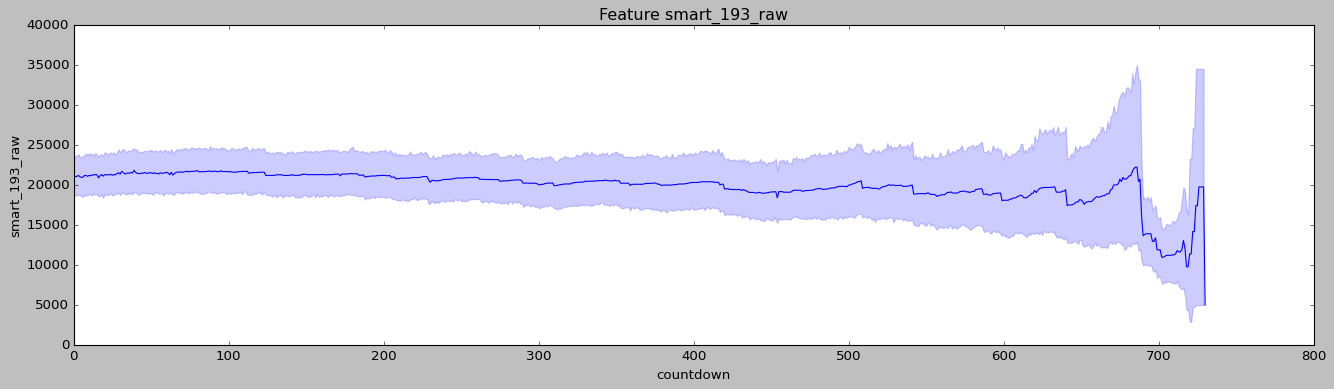

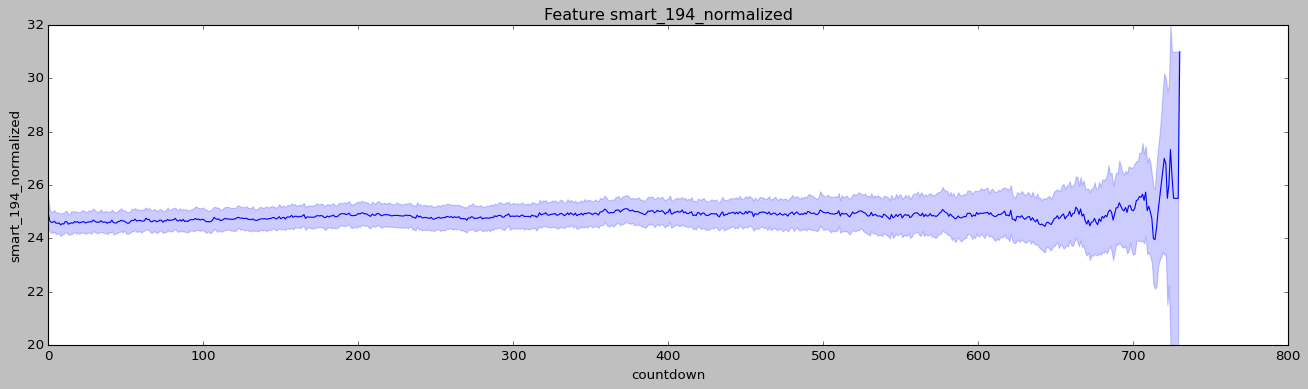

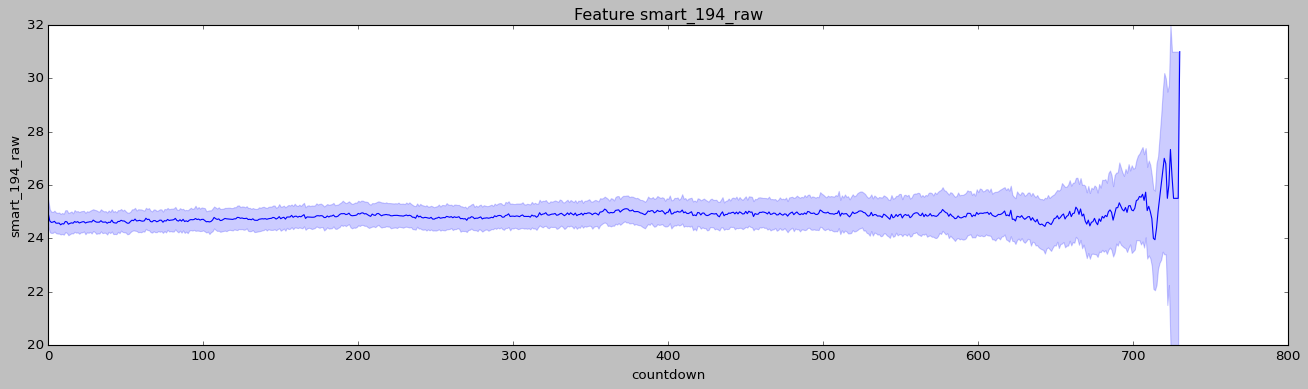

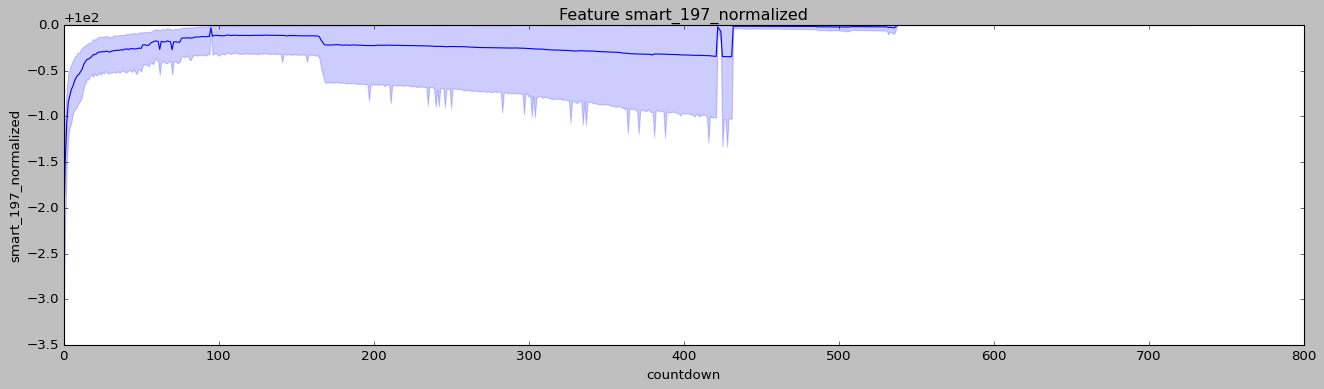

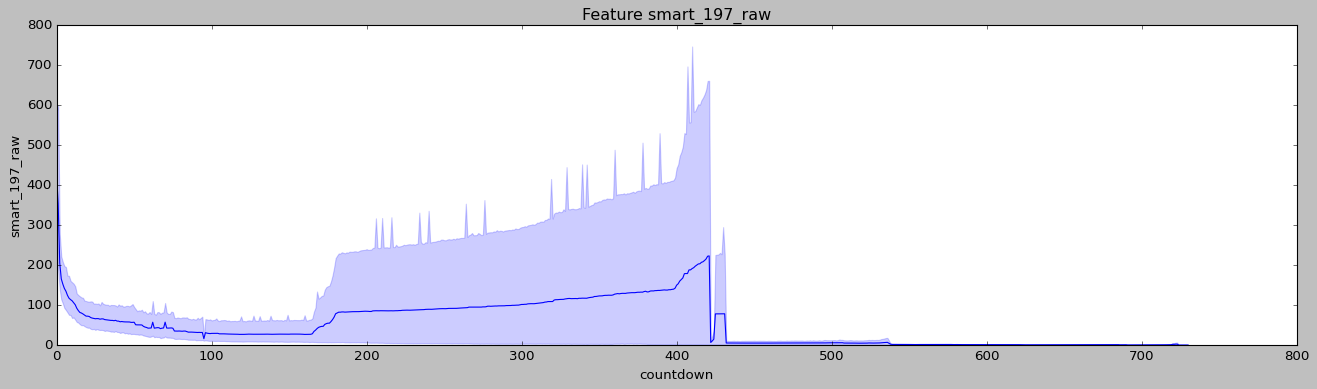

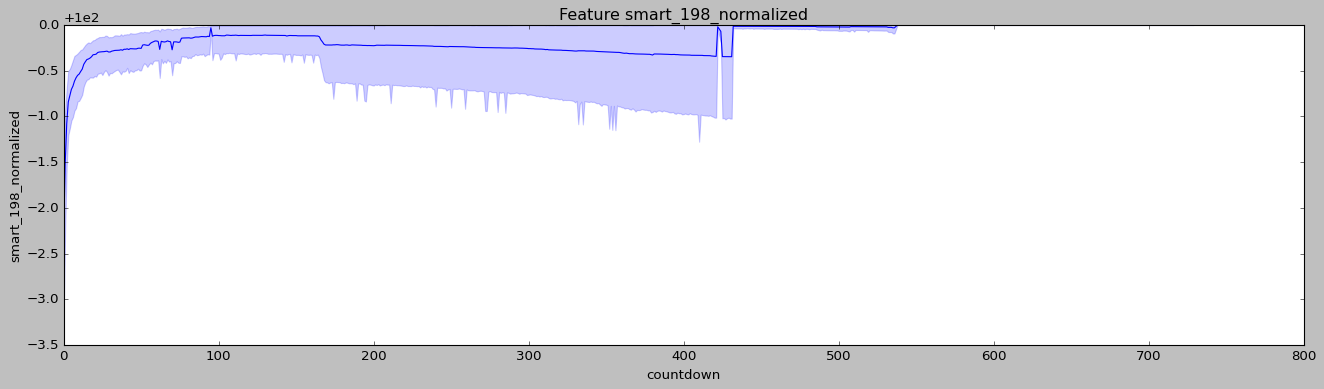

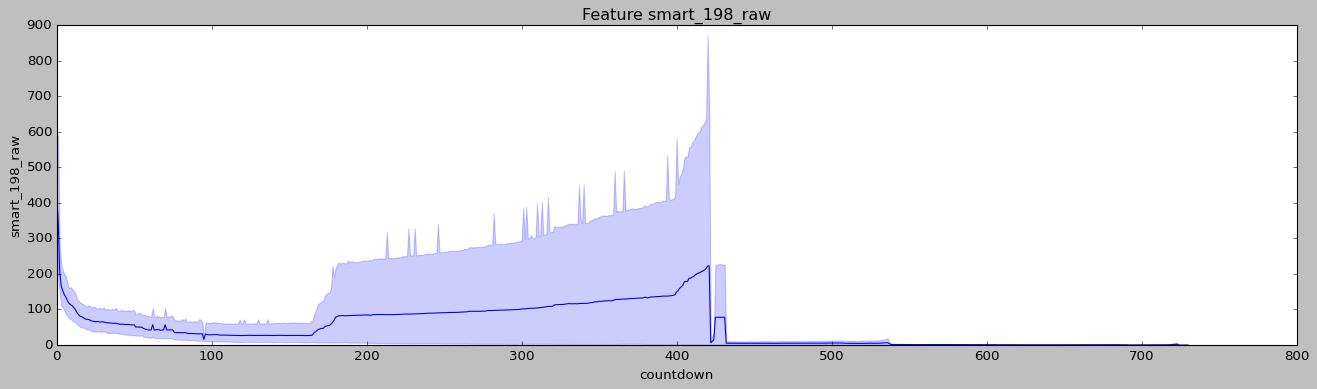

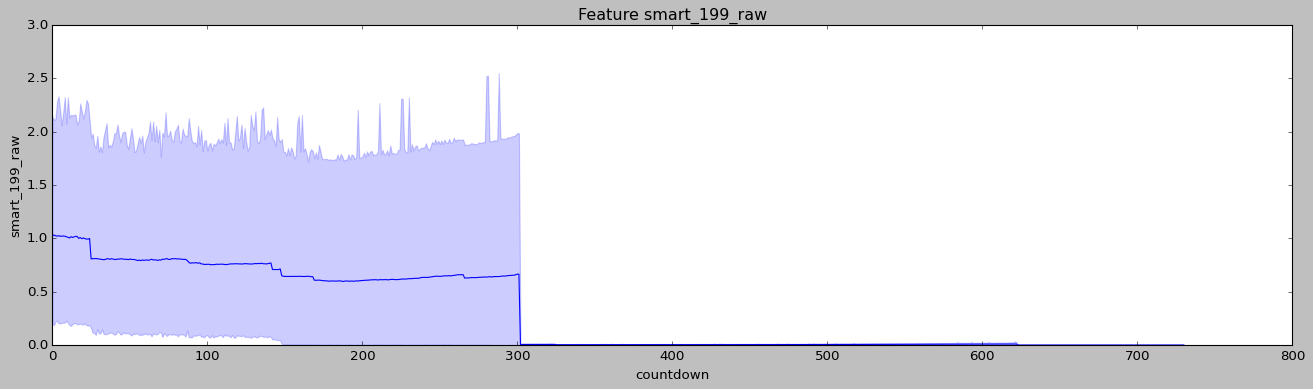

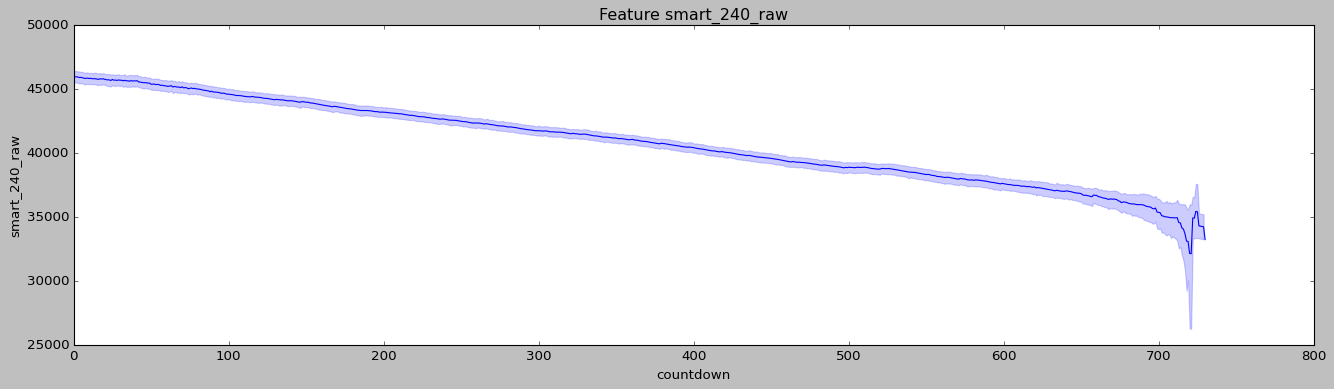

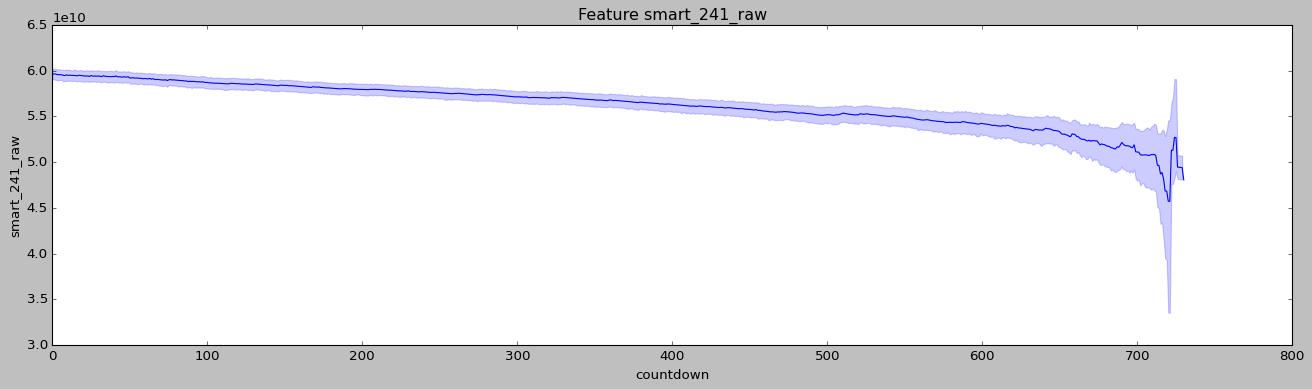

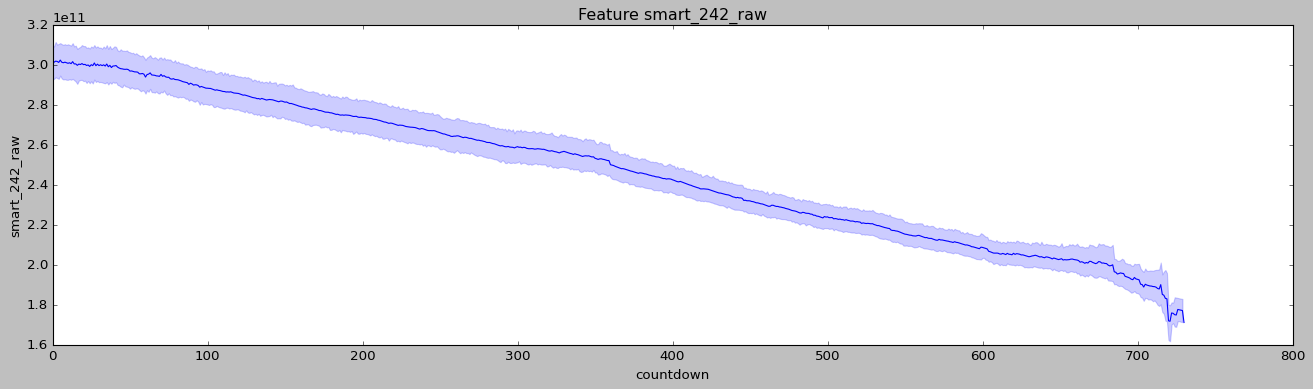

In [110]:
# plt.figure(figsize=(20,5))
# sns.lineplot(data=test_model_history, x='countdown', y=columns[3]);

for col in columns:
    plt.subplots(1, 1, figsize=(20, 5))
    g = sns.lineplot(data=test_model_history, x='countdown', y=col)
    g.set_title(f'Feature {col}')

In [133]:
new_serials = pd.read_csv('../data/special_purpose/ST4000DM000_new.csv')

In [134]:
new_serials.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-09-27,Z304JM7B,ST4000DM000,4000787030016,0,111.0,31667400.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-27,Z304JM74,ST4000DM000,4000787030016,0,117.0,137822312.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-27,Z304JGFD,ST4000DM000,4000787030016,0,117.0,134233864.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-27,Z304JMSQ,ST4000DM000,4000787030016,0,105.0,9066192.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-27,Z304JSQQ,ST4000DM000,4000787030016,0,117.0,164126104.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
test = new_serials.serial_number.value_counts().reset_index()

test.query('serial_number != 732')

,index,serial_number
485,Z304JN1Y,731
486,Z304JMN2,731
487,Z304JN6Q,731
488,Z304JKEQ,731
489,Z304JGDQ,731
490,Z304A3PD,355
491,W300SP1V,233
492,W3009EJ4,232
493,Z300WPVD,232
494,Z300WPM2,229


## Baseline Model

The first baseline model for the regression classifier will be built using a dummy regressor which takes the mean as the predicted value.

To achieve this task we import the required libraries, define our X and y features, split the data into training and test set and than instanciate the dummy regressor.
In the next step we fit and predict using the dummy regressor and calculate the mean squared error (mse) for the predicted values.


In [33]:
# Load libraries
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [68]:
test_model_history.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_200_normalized,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
0,2020-09-15,ZCH09KEF,ST12000NM0007,0,82.0,170352480.0,89.0,18.0,100.0,0.0,...,0.0,100.0,0.0,0.0,100.0,23312.0,7.000373e+10,2.133700e+11,2021-01-09,116.0
1,2020-09-15,ZJV39XZ8,ST12000NM0007,0,80.0,89314784.0,95.0,4.0,99.0,6728.0,...,0.0,100.0,0.0,0.0,100.0,8575.0,5.908189e+10,1.289960e+11,2021-07-14,302.0
2,2020-09-15,ZJV4P808,ST12000NM0007,0,80.0,109813344.0,98.0,2.0,100.0,0.0,...,0.0,100.0,0.0,0.0,100.0,8563.0,5.837710e+10,1.294771e+11,2021-10-21,401.0
3,2020-09-15,ZJV4KXBA,ST12000NM0007,0,76.0,43037216.0,92.0,6.0,100.0,0.0,...,0.0,100.0,0.0,0.0,100.0,8565.0,5.859033e+10,1.291970e+11,2021-07-12,300.0
4,2020-09-15,ZCH0CJRV,ST12000NM0007,0,81.0,123801328.0,90.0,8.0,100.0,0.0,...,0.0,100.0,0.0,0.0,100.0,23021.0,6.321736e+10,2.423267e+11,2021-08-04,323.0


In [69]:
# define the X features, droping any feature that is an indication of failure and assigning it to X and saving the target variable into y
X = test_model_history.drop(['failure', 'date', 'date_failure', 'countdown', 'serial_number', 'model'], axis=1)
y = test_model_history.countdown

In [70]:
# splitting the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [71]:
# instantiate the dummy regressor and defining the strategy for our baseline predictions
dummy_mean = DummyRegressor(strategy='mean')

# fit the dummy regressor
dummy_mean.fit(X_train, y_train)

# use the dummy regressor to predict the test set
y_test_pred = dummy_mean.predict(X_test)

In [72]:
# calculate the mean squared error for our test set
mse = mean_squared_error(y_test, y_test_pred)
print(f'The mean squared error for the baseline model is: {round(mse, 3)}')

The mean squared error for the baseline model is: 25901.082


## Linear Regression

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [74]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [75]:
lin_reg = LinearRegression()

In [76]:
lin_reg.fit(X_train, y_train)
y_pred_test = lin_reg.predict(X_test)

In [77]:
# calculate the mean squared error for our test set
mse = mean_squared_error(y_test, y_pred_test)
print(f'The mean squared error for the baseline model is: {round(mse, 3)}')

The mean squared error for the baseline model is: 20363.321


In [78]:
y_pred_test_df = pd.Series(y_pred_test, name='pred').reset_index()
y_test_df = pd.Series(y_test, name='true').reset_index()

y_pred_test_df.drop('index', axis=1, inplace=True)
y_test_df.drop('index', axis=1, inplace=True)

In [79]:
# crate an overview about the predicted and true value for the test set and add a differenc column
result = pd.concat([y_pred_test_df, y_test_df], axis=1)
result['difference'] = result['pred'] - result['true']
result.sort_values('true')

,pred,true,difference
12099,215.762753,0.0,215.762753
15329,317.211258,0.0,317.211258
15348,154.239983,0.0,154.239983
15403,-13.834341,0.0,-13.834341
1879,279.755789,0.0,279.755789
...,...,...,...
17355,335.049531,717.0,-381.950469
15715,335.557271,718.0,-382.442729
81,336.444139,720.0,-383.555861
3453,337.986071,725.0,-387.013929
